<h1 align= center>Cancer Prediction Case Study

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')
import re
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix , log_loss
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
import math
from collections import Counter , defaultdict
from sklearn.preprocessing import normalize
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import sys   # for stacking
import six   # for stacking
sys.modules['sklearn.externals.six'] = six
from mlxtend.classifier import StackingClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h3>Importing Gene, Variation & Class data



In [ ]:
df_gene_var = pd.read_csv("/content/gdrive/My Drive/Cancer Prediction/training_variants")
print("Number of data points: ",df_gene_var.shape[0])
print("Number of Features: ",df_gene_var.shape[1])
print("Features: ", df_gene_var.columns.values)
df_gene_var.head()

Number of data points:  3321
Number of Features:  4
Features:  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<h3>Importing Text data

In [ ]:
df_text = pd.read_csv("/content/gdrive/MyDrive/Cancer Prediction/training_text", sep='\|\|', engine='python', names=['ID', 'TEXT'] , skiprows=1)
print("Number of data points: ",df_text.shape[0])
print("Number of Features: ",df_text.shape[1])
print("Features: ",df_text.columns.values)
df_text.head()

Number of data points:  3321
Number of Features:  2
Features:  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


<h3>Some little preprocessing

In [ ]:
# importing stopwords
stop_words = set(stopwords.words('english'))
# creating function for preprocessing text
def nlp_preprocessing(total_text, index, column):
  if type(total_text) is not int:
    string = ""
    # replace every special chracter with splace
    total_text = re.sub('[^a-zA-Z0-9\n]',' ',total_text)
    # replace multiple spaces with single space
    total_text = re.sub('\s+',' ', total_text)
    # lower case the text
    total_text = total_text.lower()

    # Take the sentence and change the o/p to words
    # split() function working---> I/P "welcome to the jungle"    O/P['welcome', 'to', 'the', 'jungle']
    for word in total_text.split():
      if word not in stop_words:
        string += word + ' '
    df_text[column][index] = string

In [ ]:
#
start_time = time.clock()
for index, row in df_text.iterrows():
  if type(row['TEXT']) is str:
    nlp_preprocessing(row['TEXT'],index,'TEXT')
  else:
    print("There is no Description for Index: ",index)
print("Total Time Taken for nlp preprocessing: ",time.clock() - start_time," seconds")



There is no Description for Index:  1109
There is no Description for Index:  1277
There is no Description for Index:  1407
There is no Description for Index:  1639
There is no Description for Index:  2755
Total Time Taken for nlp preprocessing:  41.555978  seconds


<h3>Merging both gene, Variation and Text dataset

In [ ]:
result = pd.merge(df_gene_var, df_text, on='ID', how='left')
print("Shape of resultant data: ",result.shape)
result.head()

Shape of resultant data:  (3321, 5)


,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [ ]:
#Finding the null values
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [ ]:
# Now adding gene and variation inplace of null text
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] + " " + result['Variation']
result[result['ID'] == 1109]
# result['ID'] == 1109  df inside df
# 0       False
# 1       False
# 2       False
# 3       False
# 4       False

#       ...
# 3316    False
# 3317    False
# 3318    False
# 3319    False
# 3320    False
# Name: ID, Length: 3321, dtype: bool

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


<h3> Splitting of data for Train, Cross Validate and Test.

In [ ]:
y = result['Class']
#result = result.drop('Class',axis=1)
# 80% Train data and 20% Test data
x_train1, x_test, y_train1, y_test = train_test_split(result , y , stratify= y , test_size= 0.2)
# 80% Train data and 20% Test data
x_train, x_cv, y_train, y_cv = train_test_split(x_train1, y_train1, stratify= y_train1, test_size=0.2)

In [ ]:
x_train.head(2)

,ID,Gene,Variation,Class,TEXT
1661,1661,FLT3,R834Q,7,mutations juxtamembrane kinase domains flt3 co...
1847,1847,PPP6C,S270L,4,mutations ppp6c catalytic subunit protein phos...


In [ ]:
print("Number of data point in train set: ",x_train.shape[0])
print("Number of data point in Cross Validate set: ",x_cv.shape[0])
print("Number of data point in Test set: ",x_test.shape[0])

Number of data point in train set:  2124
Number of data point in Cross Validate set:  532
Number of data point in Test set:  665


<h3> Now it's time to analyse the Distribution of data.

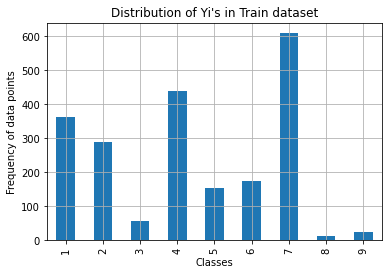

Number of data points in class  7 : 609 ( 28.672 %)
Number of data points in class  4 : 439 ( 20.669 %)
Number of data points in class  1 : 363 ( 17.09 %)
Number of data points in class  2 : 289 ( 13.606 %)
Number of data points in class  6 : 176 ( 8.286 %)
Number of data points in class  5 : 155 ( 7.298 %)
Number of data points in class  3 : 57 ( 2.684 %)
Number of data points in class  9 : 24 ( 1.13 %)
Number of data points in class  8 : 12 ( 0.565 %)
------------------------------------------------------------------------------------------------------------------------------------------------------


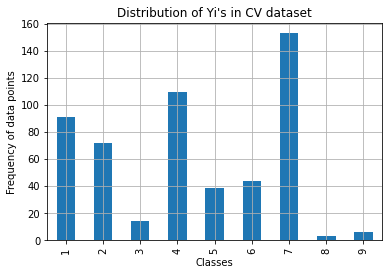

Number of data points in class  7 : 153 ( 28.759 %)
Number of data points in class  4 : 110 ( 20.677 %)
Number of data points in class  1 : 91 ( 17.105 %)
Number of data points in class  2 : 72 ( 13.534 %)
Number of data points in class  6 : 44 ( 8.271 %)
Number of data points in class  5 : 39 ( 7.331 %)
Number of data points in class  3 : 14 ( 2.632 %)
Number of data points in class  9 : 6 ( 1.128 %)
Number of data points in class  8 : 3 ( 0.564 %)
------------------------------------------------------------------------------------------------------------------------------------------------------


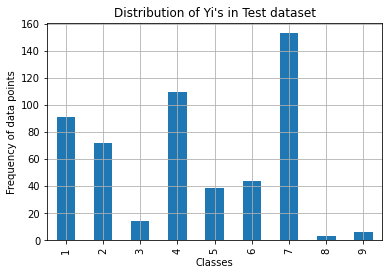

Number of data points in class  7 : 191 ( 28.722 %)
Number of data points in class  4 : 137 ( 20.602 %)
Number of data points in class  1 : 114 ( 17.143 %)
Number of data points in class  2 : 91 ( 13.684 %)
Number of data points in class  6 : 55 ( 8.271 %)
Number of data points in class  5 : 48 ( 7.218 %)
Number of data points in class  3 : 18 ( 2.707 %)
Number of data points in class  9 : 7 ( 1.053 %)
Number of data points in class  8 : 4 ( 0.602 %)


In [ ]:
train_class_distribution = x_train['Class'].value_counts().sort_index()
cv_class_distribution    = x_cv['Class'].value_counts().sort_index()
test_class_distribution  = x_test['Class'].value_counts().sort_index()


train_class_distribution.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Frequency of data points')
plt.title("Distribution of Yi's in Train dataset")
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
  print("Number of data points in class ",i+1,":",train_class_distribution.values[i],"(",np.round(train_class_distribution.values[i]/y_train.shape[0]*100,3),"%)")


print("-"*150)
cv_class_distribution.plot(kind='bar')
plt.xlabel("Classes")
plt.ylabel("Frequency of data points")
plt.title("Distribution of Yi's in CV dataset")
plt.grid()
plt.show()

sorted_y = np.argsort(-cv_class_distribution.values)
for i in sorted_y:
  print("Number of data points in class ",i+1,":",cv_class_distribution.values[i],"(",np.round(cv_class_distribution.values[i]/y_cv.shape[0]*100,3),"%)")


print("-"*150)
cv_class_distribution.plot(kind='bar')
plt.xlabel("Classes")
plt.ylabel("Frequency of data points")
plt.title("Distribution of Yi's in Test dataset")
plt.grid()
plt.show()

sorted_y = np.argsort(-cv_class_distribution.values)
for i in sorted_y:
  print("Number of data points in class ",i+1,":",test_class_distribution.values[i],"(",np.round(test_class_distribution.values[i]/y_test.shape[0]*100,3),"%)")

By observing Gene feature we observe that their train, cv, and test dataset follows similar distribution which is good.

In [ ]:
def plot_confusion_matrix(y_test , predicted_y):
  C = confusion_matrix(y_test , predicted_y)
  A = (((C.T)/(C.sum(axis=1))).T)   # precison column sum
  B = (C/C.sum(axis=0))       # recall   row sum

  label = [1,2,3,4,5,6,7,8,9]
  plt.figure(figsize=(20,7))
  sns.heatmap(C, annot=True, cmap="YlGnBu", fmt="0.3f", xticklabels=label, yticklabels=label)
  print("-"*60, "Confusion matrix", "-"*60)
  plt.xlabel("Predicted Class")
  plt.ylabel("Original Class")
  plt.show()

  plt.figure(figsize=(20,7))
  sns.heatmap(A, fmt='0.3f', annot=True, cmap="YlGnBu" , xticklabels=label , yticklabels=label)
  print("-"*60,"Precision Martix axis=1","-"*60)
  plt.xlabel("Predicted Class")
  plt.ylabel("Original Class")
  plt.show()

  plt.figure(figsize=(20,7))
  sns.heatmap(B, fmt='0.3f', annot=True, cmap="YlGnBu" , xticklabels=label , yticklabels=label)
  print("-"*60,"Recall Martix axis=0","-"*60)
  plt.xlabel("Predicted Class")
  plt.ylabel("Original Class")
  plt.show()

logloss for train dataset is:  2.470811804229691
Logloss for Cross Validate dataset is:  2.476160510248127
Logloss for test dataset is:  2.4610290188282096
------------------------------------------------------------ Confusion matrix ------------------------------------------------------------


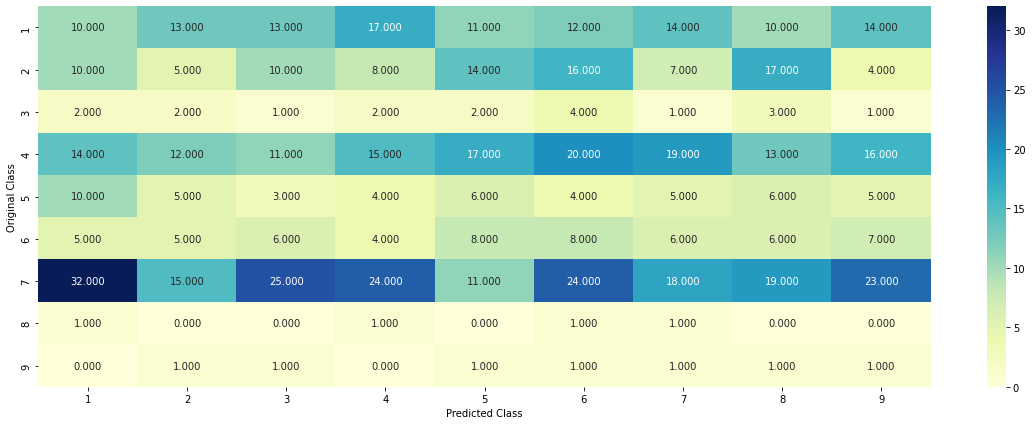

------------------------------------------------------------ Precision Martix axis=1 ------------------------------------------------------------


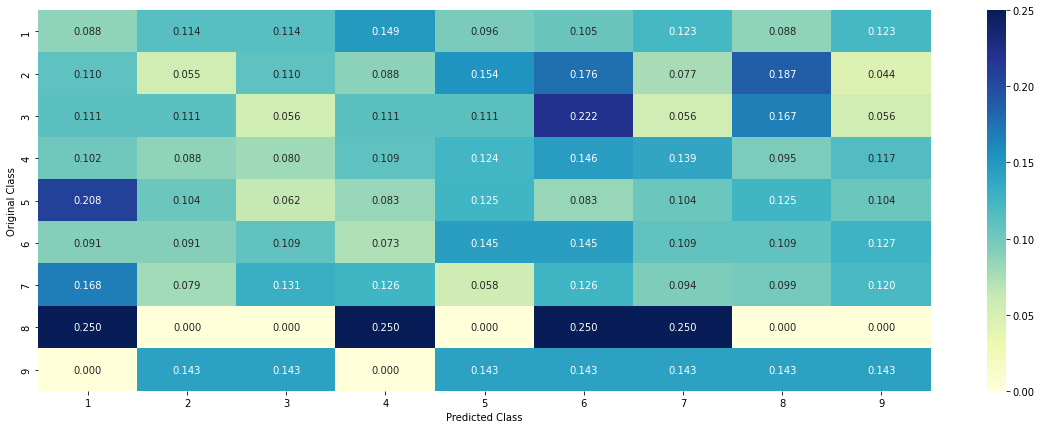

------------------------------------------------------------ Recall Martix axis=0 ------------------------------------------------------------


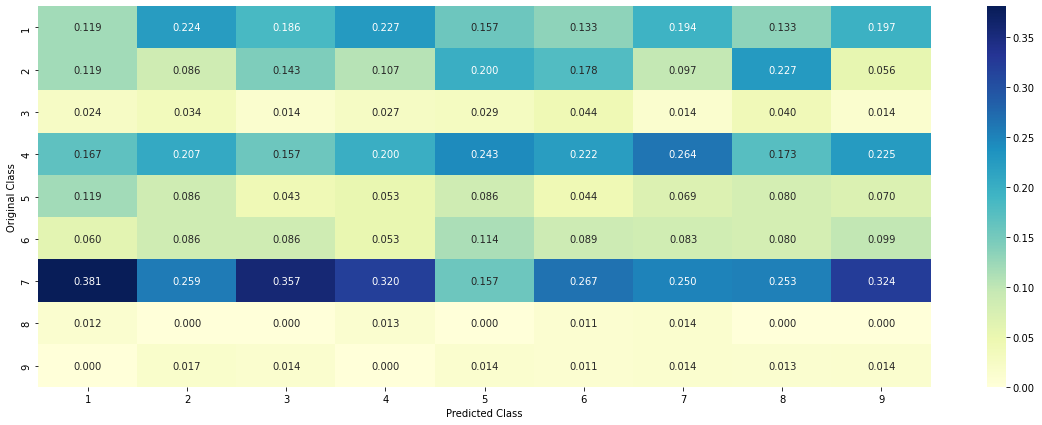

In [ ]:
train_data_len = x_train.shape[0]  # length is 2124
cv_data_len    = x_cv.shape[0]     # length is 532
test_data_len  = x_test.shape[0]   # length is 665
# we need to generate random 9 random numbers and their sum should be 1.
# One solution is to generate 9 numbers and divide each number with their sum
train_predict_y = np.zeros((train_data_len,9))
for i in range(train_data_len):
  rand_probs = np.random.rand(1,9)
  train_predict_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("logloss for train dataset is: ", log_loss(y_train , train_predict_y, eps=1e-15))

cv_predict_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
  rand_probs = np.random.rand(1,9)
  cv_predict_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Logloss for Cross Validate dataset is: ",log_loss(y_cv , cv_predict_y, eps=1e-15))

test_predict_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
  rand_probs = np.random.rand(1,9)
  test_predict_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Logloss for test dataset is: ",log_loss(y_test , test_predict_y , eps=1e-15))
predicted_y = np.argmax(test_predict_y,axis=1)
plot_confusion_matrix(y_test , predicted_y+1)

In [ ]:
# Function for response coding
def get_gv_feat_dict(alpha, feature,df):
  value_count = x_train[feature].value_counts()
  gv_dict=dict()
  for i, denominator in value_count.items():
    vec = []
    for k in range(1,10):
      cls_cnt = x_train.loc[(x_train['Class']==k) & (x_train[feature]==i)]
      vec.append((cls_cnt.shape[0] + alpha*10) / (denominator + alpha*90))
    gv_dict[i] = vec
  return gv_dict

def get_gv_feature(alpha, feature, df):
  gv_dict     = get_gv_feat_dict(alpha, feature, df)
  value_count = x_train[feature].value_counts()
  gv_feat=[]
  for index,row in df.iterrows():
    if row[feature] in dict(value_count).keys():
      gv_feat.append(gv_dict[row[feature]])
    else:
      gv_feat.append([1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9])
  return gv_feat

<h3>Univarient Analysis of Gene Feature

In [ ]:
unique_gene = x_train['Gene'].value_counts()
print("Number of unique genes: ",unique_gene.shape[0])
print("Top 10 Gene features in train dataset: ")
top_10_g = x_train['Gene'].value_counts()
top_10_g.head(10)

Number of unique genes:  230
Top 10 Gene features in train dataset: 


BRCA1     172
EGFR      101
TP53      100
PTEN       86
BRCA2      82
KIT        65
BRAF       60
PDGFRA     41
ALK        40
ERBB2      38
Name: Gene, dtype: int64

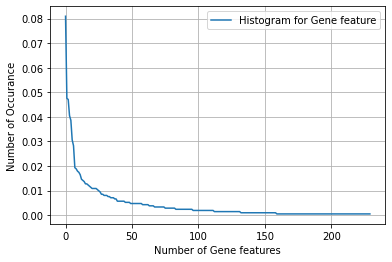

In [ ]:
# plotting histogram for Gene feature
s = sum(unique_gene.values)
h = unique_gene.values/s
plt.plot(h,label="Histogram for Gene feature")
plt.xlabel("Number of Gene features")
plt.ylabel("Number of Occurance")
plt.grid()
plt.legend()
plt.show()

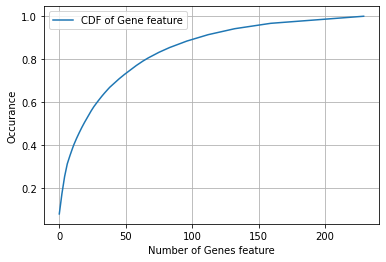

In [ ]:
c = np.cumsum(h)
plt.plot(c, label="CDF of Gene feature")
plt.legend()
plt.xlabel("Number of Genes feature")
plt.ylabel("Occurance")
plt.grid()
plt.show()

In [ ]:
alpha = 1
train_gene_ResponseCoding = np.array(get_gv_feature(alpha,'Gene', x_train))
cv_gene_ResponseCoding    = np.array(get_gv_feature(alpha,'Gene', x_cv))
test_gene_ResponseCoding  = np.array(get_gv_feature(alpha, 'Gene', x_test))
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_ResponseCoding.shape)
print("cv_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", cv_gene_ResponseCoding.shape)
print("testn_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", test_gene_ResponseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)
cv_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (532, 9)
testn_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (665, 9)


In [ ]:
gene_encoding = CountVectorizer()
train_gene_onehotencode  = gene_encoding.fit_transform(x_train['Gene'])  # One time fit
cv_gene_onehotencode     = gene_encoding.transform(x_cv['Gene'])    # No need to fit
test_gene_onehotencode = gene_encoding.transform(x_test['Gene'])
print("train_gene_onehotencoding is converted feature using onehot encoding method. The shape of gene feature:", train_gene_onehotencode.shape)
print("cv_gene_onehotencoding is converted feature using onehot encoding method. The shape of gene feature:", cv_gene_onehotencode.shape)
print("test_gene_onehotencoding is converted feature using onehot encoding method. The shape of gene feature:", test_gene_onehotencode.shape)

train_gene_onehotencoding is converted feature using onehot encoding method. The shape of gene feature: (2124, 229)
cv_gene_onehotencoding is converted feature using onehot encoding method. The shape of gene feature: (532, 229)
test_gene_onehotencoding is converted feature using onehot encoding method. The shape of gene feature: (665, 229)


In [ ]:
gene_encoding.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1b',
 'arid2',
 'arid5b',
 'asxl1',
 'asxl2',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bcl10',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'egfr',
 'elf3',
 'ep300',
 'epas1',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fanca',
 'fat1',
 'fbxw7',
 'fgf3',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt3',
 'foxa1',
 'foxl2',
 'foxp1',
 'fubp1',
 'gata3',
 'gli1',
 'gna11',
 'gnas',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r',
 'ikbke',
 'il7r',


<h3>Modelling using Logistic Regression

LogLoss for alpha 1e-05 is:  1.1938429418727896
LogLoss for alpha 0.0001 is:  1.1799408115063472
LogLoss for alpha 0.001 is:  1.239097250191419
LogLoss for alpha 0.01 is:  1.3726607421328307
LogLoss for alpha 0.1 is:  1.4870232172431697
LogLoss for alpha 1 is:  1.51937134805121
LogLoss for alpha 10 is:  1.5231969989072416


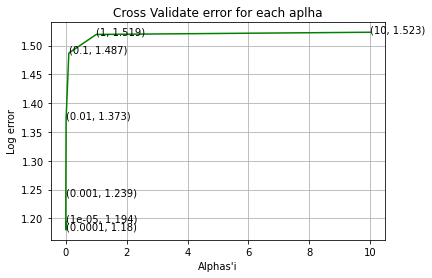

For value of best alpha 0.0001  the logloss is:  1.0040492075534777
For value of best alpha 0.0001  the logloss is:  1.1799408115063472
For value of best alpha 0.0001  the logloss is:  1.1980153162458622


In [ ]:
cv_log_error = []
alpha = [10 ** x for x in range(-5 , 2 )]
for i in alpha:
  clf   = SGDClassifier(alpha= i, penalty= 'l2' , loss='log', random_state= 42, n_jobs= -1)
  clf.fit(train_gene_onehotencode, y_train)
  sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
  sig_clf.fit(train_gene_onehotencode, y_train)
  y_predicted = sig_clf.predict_proba(cv_gene_onehotencode)
  cv_log_error.append(log_loss(y_cv, y_predicted, labels= clf.classes_ , eps=1e-15))
  print("LogLoss for alpha",i,"is: ",log_loss(y_cv, y_predicted, labels= clf.classes_, eps=1e-15))

fig,ax = plt.subplots()
ax.plot(alpha, cv_log_error, c='g')
for i, txt in enumerate(np.round(cv_log_error,3)):
  ax.annotate((alpha[i],np.round(txt,3)), (alpha[i], cv_log_error[i]))
plt.title("Cross Validate error for each aplha")
plt.xlabel("Alphas'i")
plt.ylabel("Log error")
plt.grid()
plt.show()

best_alpha= np.argmin(cv_log_error)
clf = SGDClassifier(alpha = alpha[best_alpha], penalty='l2', random_state=42, loss='log', n_jobs=-1)
clf.fit(train_gene_onehotencode, y_train)
sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
# sig_clf = CalibratedClassifierCV(clf, method = 'isotonic')
# For value of best alpha 1  the logloss is:  0.9549938260739086
# For value of best alpha 1  the logloss is:  1.3962269548727062
# For value of best alpha 1  the logloss is:  1.3576217932980164

sig_clf.fit(train_gene_onehotencode, y_train)

y_predicted = sig_clf.predict_proba(train_gene_onehotencode)
print("For value of best alpha", alpha[best_alpha] , " the logloss is: ",log_loss(y_train, y_predicted, labels=clf.classes_, eps=1e-15))

y_predicted = sig_clf.predict_proba(cv_gene_onehotencode)
print("For value of best alpha", alpha[best_alpha], " the logloss is: ", log_loss(y_cv, y_predicted , labels= clf.classes_, eps=1e-15))

y_predicted = sig_clf.predict_proba(test_gene_onehotencode)
print("For value of best alpha", alpha[best_alpha], " the logloss is: ",log_loss(y_test, y_predicted, labels=clf.classes_, eps=1e-15))


Hence by observing Train, Cross Validate and Test logloss, it is clear that our Logistic Regression Model is not Overfitting and Underfitting.

In [ ]:
print("Finding how many datapoint of Test and Cross Validate are present in Train dataset.")
test_coverage = x_test[x_test['Gene'].isin(list(set(x_train['Gene'])))].shape[0]
cv_coverage   = x_cv[x_cv['Gene'].isin(list(set(x_train['Gene'])))].shape[0]
print("Out of ",x_test.shape[0] , " datapoints", test_coverage , " are present in Train dataset.", np.round((test_coverage/x_test.shape[0])*100 , 3),"%")
print("Out of ",x_cv.shape[0], " datapoints", cv_coverage , " are present in Train dataset.", np.round((cv_coverage/x_cv.shape[0])*100 , 3),"%")

Finding how many datapoint of Test and Cross Validate are present in Train dataset.
Out of  665  datapoints 641  are present in Train dataset. 96.391 %
Out of  532  datapoints 513  are present in Train dataset. 96.429 %


Hence, it is clear that all the three (Train, CrossValidate and Test) datasets follows similar distribution.

<h3> Univarient Analysis of Variation Feature

In [ ]:
unique_var = x_train['Variation'].value_counts()
top_10_var = x_train.Variation.value_counts()
print("Top 10 Variation")
top_10_var.head(10)

Top 10 Variation


Truncating Mutations         58
Amplification                49
Deletion                     42
Fusions                      26
G12V                          3
Overexpression                3
T167A                         2
A146V                         2
Promoter Hypermethylation     2
S222D                         2
Name: Variation, dtype: int64

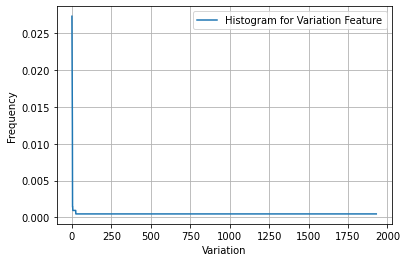

In [ ]:
# plotting histogram
s = sum(unique_var.values)
h = unique_var.values/s
plt.plot(h, label="Histogram for Variation Feature")
plt.xlabel('Variation')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

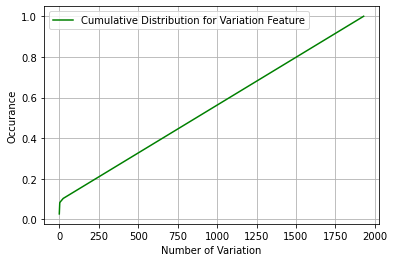

In [ ]:
# plotting Cumulative Distribution
c = np.cumsum(h)
plt.plot(c, label="Cumulative Distribution for Variation Feature", c='g')
plt.xlabel("Number of Variation")
plt.ylabel('Occurance')
plt.legend()
plt.grid()
plt.show()

<h3> Calling Response Coding for Variation feature

In [ ]:
alpha =1
train_var_ResponseCode = np.array(get_gv_feature(alpha, 'Variation', x_train))
cv_var_ResponseCode     = np.array(get_gv_feature(alpha, 'Variation', x_cv))
test_var_ResponseCode   = np.array(get_gv_feature(alpha, 'Variation', x_test))
print("After Response Coding Train dataset looks like: ",train_var_ResponseCode.shape)
print("After Response Coding Cross Validate dataset looks like: ",cv_var_ResponseCode.shape)
print("After Response Coding Test dataset looks like: ",test_var_ResponseCode.shape)

After Response Coding Train dataset looks like:  (2124, 9)
After Response Coding Cross Validate dataset looks like:  (532, 9)
After Response Coding Test dataset looks like:  (665, 9)


<h3>Variation Feature using OneHot Encoding

In [ ]:
var_encoding = CountVectorizer()
train_var_onehotencode = var_encoding.fit_transform(x_train['Variation'])
cv_var_onehotencode    = var_encoding.transform(x_cv['Variation'])
test_var_onehotencode  = var_encoding.transform(x_test['Variation'])
print("Train dataset after applying One Hot Encoding looks like: ",train_var_onehotencode.shape)
print("Cross Validate dataset after applying One Hot Encoding looks like: ",cv_var_onehotencode.shape)
print("Test dataset after applying One Hot Encoding looks like: ",test_var_onehotencode.shape)

Train dataset after applying One Hot Encoding looks like:  (2124, 1961)
Cross Validate dataset after applying One Hot Encoding looks like:  (532, 1961)
Test dataset after applying One Hot Encoding looks like:  (665, 1961)


In [ ]:
var_encoding.get_feature_names()

['126',
 '13',
 '17',
 '19',
 '1_2009trunc',
 '20',
 '256_286trunc',
 '422_605trunc',
 '51',
 '6a',
 '963_d1010splice',
 'a1022e',
 'a1065t',
 'a111p',
 'a1170v',
 'a1200v',
 'a120s',
 'a121e',
 'a122',
 'a1234t',
 'a126d',
 'a126g',
 'a126v',
 'a134d',
 'a146t',
 'a146v',
 'a148t',
 'a149p',
 'a1519t',
 'a151t',
 'a1685s',
 'a1701p',
 'a1708e',
 'a1708v',
 'a1752p',
 'a1752v',
 'a1823t',
 'a1830t',
 'a1843p',
 'a1843t',
 'a18d',
 'a197t',
 'a2034v',
 'a205t',
 'a209t',
 'a2351g',
 'a2425t',
 'a246p',
 'a263v',
 'a2643g',
 'a2717s',
 'a2770t',
 'a290t',
 'a298t',
 'a339v',
 'a347t',
 'a349p',
 'a34d',
 'a389t',
 'a39p',
 'a41p',
 'a41t',
 'a459v',
 'a504_y505ins',
 'a530t',
 'a530v',
 'a532h',
 'a598t',
 'a598v',
 'a59t',
 'a60v',
 'a614d',
 'a633t',
 'a633v',
 'a634d',
 'a634v',
 'a636p',
 'a677g',
 'a707t',
 'a717g',
 'a723d',
 'a727v',
 'a728v',
 'a72s',
 'a750_e758del',
 'a750p',
 'a75p',
 'a763_y764insfqea',
 'a767_v769dup',
 'a77p',
 'a77s',
 'a77t',
 'a829p',
 'a859_l883delinsv'

<h3> Modeling Variation feature with Logistic Regression using Response Coding

For alpha  1e-05  logloss is:  2.207098108919576
For alpha  0.0001  logloss is:  2.1038324782577975
For alpha  0.001  logloss is:  2.0014741445749826
For alpha  0.01  logloss is:  1.781997649498826
For alpha  0.1  logloss is:  1.8303536242315765
For alpha  1  logloss is:  1.8303536242674052
For alpha  10  logloss is:  1.8303536255236392


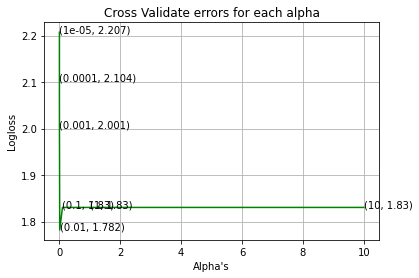

For alpha  0.01  the logloss on Test dataset is:  1.789670113085929
For alpha  0.01  the logloss on Train dataset is:  1.765256915743442
For alpha  0.01  the logloss on Cross Validate dataset is:  1.781997649498826


In [ ]:
alpha = [10 ** x for x in range(-5,2)]
cv_log_error = []
for i in alpha:
  clf = SGDClassifier(alpha= i, penalty='l1',loss='log', n_jobs= -1, random_state=42)
  clf.fit(train_var_ResponseCode, y_train)
  sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
  sig_clf.fit(train_var_ResponseCode, y_train)
  y_predicted = sig_clf.predict_proba(cv_var_ResponseCode)
  cv_log_error.append(log_loss(y_cv, y_predicted, labels=clf.classes_, eps=1e-15))
  print("For alpha ", i," logloss is: ",log_loss(y_cv, y_predicted, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error, c='g')
for i, txt in enumerate(np.round(cv_log_error,3)):
  ax.annotate((alpha[i], np.round(txt,3)), (alpha[i], cv_log_error[i]))
plt.title("Cross Validate errors for each alpha")
plt.xlabel("Alpha's")
plt.ylabel("Logloss")
plt.grid()
plt.show()


best_alpha = np.argmin(cv_log_error)

clf = SGDClassifier(alpha = alpha[best_alpha], penalty='l1',loss='log', n_jobs= -1, random_state=42)
clf.fit(train_var_ResponseCode, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_var_ResponseCode, y_train)

y_predicted = sig_clf.predict_proba(test_var_ResponseCode)
print("For alpha ", alpha[best_alpha]," the logloss on Test dataset is: ",log_loss(y_test, y_predicted, labels=clf.classes_, eps=1e-15))

y_predicted = sig_clf.predict_proba(train_var_ResponseCode)
print("For alpha ", alpha[best_alpha]," the logloss on Train dataset is: ",log_loss(y_train, y_predicted, labels=clf.classes_, eps=1e-15))

y_predicted = sig_clf.predict_proba(cv_var_ResponseCode)
print("For alpha ", alpha[best_alpha]," the logloss on Cross Validate dataset is: ",log_loss(y_cv, y_predicted, labels=clf.classes_, eps=1e-15))

<h3> Modeling Variation feature with Logistic Regression using OneHot Encoding

For alpha  1e-05  logloss is:  1.717835396121652
For alpha  0.0001  logloss is:  1.7164042239012698
For alpha  0.001  logloss is:  1.7097048769561436
For alpha  0.01  logloss is:  1.7757880800119366
For alpha  0.1  logloss is:  1.8303536247739272
For alpha  1  logloss is:  1.8303536245954006
For alpha  10  logloss is:  1.830353624593319


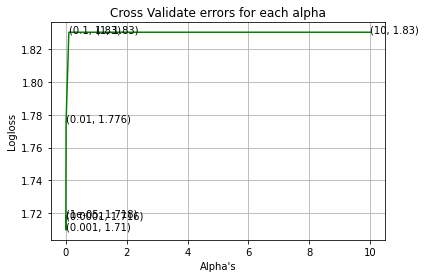

For alpha  0.001  the logloss on Test dataset is:  1.6838697482967115
For alpha  0.001  the logloss on Train dataset is:  1.6917125249451703
For alpha  0.001  the logloss on Cross Validate dataset is:  1.7097048769561436


In [ ]:
alpha = [10 ** x for x in range(-5,2)]
cv_log_error = []
for i in alpha:
  clf = SGDClassifier(alpha= i, penalty='l1',loss='log', n_jobs= -1, random_state=42)
  clf.fit(train_var_onehotencode, y_train)
  sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
  sig_clf.fit(train_var_onehotencode, y_train)
  y_predicted = sig_clf.predict_proba(cv_var_onehotencode)
  cv_log_error.append(log_loss(y_cv, y_predicted, labels=clf.classes_, eps=1e-15))
  print("For alpha ", i," logloss is: ",log_loss(y_cv, y_predicted, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error, c='g')
for i, txt in enumerate(np.round(cv_log_error,3)):
  ax.annotate((alpha[i], np.round(txt,3)), (alpha[i], cv_log_error[i]))
plt.title("Cross Validate errors for each alpha")
plt.xlabel("Alpha's")
plt.ylabel("Logloss")
plt.grid()
plt.show()


best_alpha = np.argmin(cv_log_error)

clf = SGDClassifier(alpha = alpha[best_alpha], penalty='l1',loss='log', n_jobs= -1, random_state=42)
clf.fit(train_var_onehotencode, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_var_onehotencode, y_train)

y_predicted = sig_clf.predict_proba(test_var_onehotencode)
print("For alpha ", alpha[best_alpha]," the logloss on Test dataset is: ",log_loss(y_test, y_predicted, labels=clf.classes_, eps=1e-15))

y_predicted = sig_clf.predict_proba(train_var_onehotencode)
print("For alpha ", alpha[best_alpha]," the logloss on Train dataset is: ",log_loss(y_train, y_predicted, labels=clf.classes_, eps=1e-15))

y_predicted = sig_clf.predict_proba(cv_var_onehotencode)
print("For alpha ", alpha[best_alpha]," the logloss on Cross Validate dataset is: ",log_loss(y_cv, y_predicted, labels=clf.classes_, eps=1e-15))

# Logistic reg With L1 regularization
# For alpha  0.001  the logloss on Test dataset is:  1.7134085717233352
# For alpha  0.001  the logloss on Train dataset is:  1.687610047601688
# For alpha  0.001  the logloss on Cross Validate dataset is:  1.6984516054770864

# Logistic reg With L2 regularization
# For alpha  0.0001  the logloss on Test dataset is:  1.7029377326637025
# For alpha  0.0001  the logloss on Train dataset is:  0.6604824786838963
# For alpha  0.0001  the logloss on Cross Validate dataset is:  1.689454970455003

Hence by observing Train, Cross Validate and Test logloss, it is clear that our Logistic Regression Model for Variation feature is not Overfitting and Underfitting.

In [ ]:
print("Finding how many data points for Test and Cross Validate are present in Train dataset.")
test_coverage = x_test[x_test['Variation'].isin(list(set(x_train['Variation'])))].shape[0]
cv_coverage = x_cv[x_cv['Variation'].isin(list(set(x_train['Variation'])))].shape[0]
print("Out of ",x_test.shape[0] ,"(Test) datapoints",  test_coverage, " are present in Train dataset.", "(",np.round((test_coverage/x_test.shape[0])*100,3),"%)")
print("Out of ",x_cv.shape[0] ,"(Cross Validate) datapoints",  cv_coverage, " are present in Train dataset.", "(",np.round((cv_coverage/x_cv.shape[0])*100,3),"%)")

Finding how many data points for Test and Cross Validate are present in Train dataset.
Out of  665 (Test) datapoints 75  are present in Train dataset. ( 11.278 %)
Out of  532 (Cross Validate) datapoints 47  are present in Train dataset. ( 8.835 %)


Hence, it is clear that all the three (Train, CrossValidate and Test) datasets shares little amount of same distribution.

<h3> Univerant analysis of Text feature

In [ ]:
def extract_dictonary_paddle(cls_text):
  dictionary = defaultdict(int)   #defaultdict does not raise keyvalue error
  for index, row in cls_text.iterrows():
    for word in row['TEXT'].split():
      dictionary[word] += 1
  return dictionary

In [ ]:
def get_response_code(df):
  text_feature_response_coding = np.zeros((df.shape[0],9))
  for i in range(0,9):
    row_index = 0
    for index, row in df.iterrows():
      sum_prob = 0
      for words in row['TEXT'].split():
        sum_prob += math.log(((dict_list[i].get(words,0)+10) / (total_dict.get(words,0)+90)))
      text_feature_response_coding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
      row_index += 1
    return text_feature_response_coding

In [ ]:
# buid a countvector for word occur minimum 3 times.
text_vectorizer = CountVectorizer(min_df=3)
train_text_onehotencode = text_vectorizer.fit_transform(x_train['TEXT'])
cv_text_onehotencode    = text_vectorizer.transform(x_cv['TEXT'])
test_text_onehotencode  = text_vectorizer.transform(x_test['TEXT'])
# get feature names
train_text_feat_names   = text_vectorizer.get_feature_names()

train_text_feature_count= train_text_onehotencode.sum(axis=0).A1

text_feat_dict          = dict(zip(list(train_text_feat_names), train_text_feature_count))
print("Number of unique words in dictionary: ",len(train_text_feat_names))

Number of unique words in dictionary:  53280


In [ ]:
dict_list = []
for i in range(1,10):
  cls_text = x_train[x_train["Class"] == i]
  dict_list.append(extract_dictonary_paddle(cls_text))   #

total_dict = extract_dictonary_paddle(x_train)

confuse_array = []
for i in train_text_feat_names:
  ratio = []
  max_val = -1
  for j in range(0,9):
    ratio.append((dict_list[j][i] + 10) / (total_dict[i] + 90))
  confuse_array.append(ratio)
confuse_array = np.array(confuse_array)

Calling Response Coding function for Text dataset

In [ ]:
train_text_responsecode = get_response_code(x_train)
cv_text_responsecode    = get_response_code(x_cv)
test_text_responsecode  = get_response_code(x_test)

Normalize Response Coding

In [ ]:
train_text_feat_responsecode = ((train_text_responsecode.T) / (train_text_responsecode.sum(axis=1))).T
cv_text_feat_responsecode    = ((cv_text_responsecode.T) / (cv_text_responsecode.sum(axis=1))).T
test_text_feat_responsecode  = ((test_text_responsecode.T) / (test_text_responsecode.sum(axis=1))).T

Normalize OneHot Encoding

In [ ]:
train_text_onehotencode = normalize(train_text_onehotencode , axis=0)
cv_text_onehotencode    = normalize(cv_text_onehotencode , axis =0)
test_text_onehotencode  = normalize(test_text_onehotencode , axis =0)

For alpha  1e-05  the log loss is:  1.378626835538475
For alpha  0.0001  the log loss is:  1.2792247252062663
For alpha  0.001  the log loss is:  1.410122876749546
For alpha  0.01  the log loss is:  1.8303536243464869
For alpha  0.1  the log loss is:  1.8303536247734493
For alpha  1  the log loss is:  1.8303536245954006
For alpha  10  the log loss is:  1.830353624593319


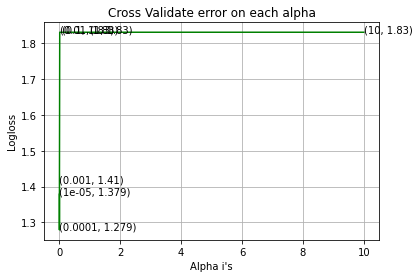

For alpha  0.0001 the test logloss is:  1.303263808809831
For alpha  0.0001 the cross validate logloss is:  1.2792247252062663
For alpha  0.0001 the train logloss is:  1.0742960444253586


In [ ]:
alpha = [10 ** x for x in range(-5,2)]
cv_log_error = []
for i in alpha:
  clf = SGDClassifier(alpha = i , penalty = 'l1' , loss= 'log' , random_state = 42 , n_jobs=-1)
  clf.fit(train_text_onehotencode , y_train)
  sig_clf = CalibratedClassifierCV(clf , method='sigmoid')
  sig_clf.fit(train_text_onehotencode , y_train)
  y_predicted = sig_clf.predict_proba(cv_text_onehotencode)
  cv_log_error.append(log_loss(y_cv , y_predicted , labels = clf.classes_ , eps=1e-15))
  print("For alpha ",i," the log loss is: ", log_loss(y_cv , y_predicted , labels= clf.classes_ , eps= 1e-15))

fig , ax = plt.subplots()
ax.plot(alpha , cv_log_error , c='g')
for i , txt in enumerate(np.round(cv_log_error , 3)):
  ax.annotate((alpha[i] , np.round(txt,3)) , (alpha[i] , cv_log_error[i]))
plt.title("Cross Validate error on each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Logloss")
plt.grid()
plt.show()

best_alpha = np.argmin(cv_log_error)

clf = SGDClassifier(alpha = alpha[best_alpha] , penalty = 'l1', loss = 'log', random_state=42, n_jobs=-1)
clf.fit(train_text_onehotencode , y_train)
sig_clf = CalibratedClassifierCV(clf , method = 'sigmoid')
sig_clf.fit(train_text_onehotencode , y_train)
y_predicted = sig_clf.predict_proba(test_text_onehotencode)
print("For alpha ",alpha[best_alpha],"the test logloss is: ", log_loss(y_test , y_predicted , labels= clf.classes_ , eps=1e-15))
y_predicted = sig_clf.predict_proba(cv_text_onehotencode)
print("For alpha ",alpha[best_alpha],"the cross validate logloss is: ", log_loss(y_cv , y_predicted , labels= clf.classes_ , eps=1e-15))
y_predicted = sig_clf.predict_proba(train_text_onehotencode)
print("For alpha ",alpha[best_alpha],"the train logloss is: ", log_loss(y_train , y_predicted , labels= clf.classes_ , eps=1e-15))


In [ ]:
def get_intersect_text(df_text):
  text_vectorizer = CountVectorizer()
  text_feat       = text_vectorizer.fit_transform(df_text['TEXT'])
  text_feat_names = text_vectorizer.get_feature_names()
  text_feat_count = text_feat.sum(axis=0).A1
  text_feat_dict  = dict(zip(list(text_feat_names),text_feat_count))

  len1 = len(set(text_feat_names))
  len2 = len(set(train_text_feat_names) & set(text_feat_names))
  return len1 , len2

In [ ]:
len1 , len2 = get_intersect_text(x_cv)
print(np.round((len2/len1) *100,3), "%  of cross_validate dataset are present in train dataset.")
len1 , len2 = get_intersect_text(x_test)
print(np.round((len2/len1) *100 , 3), "%  of test dataset are present in train dataset.")

64.872 %  of cross_validate dataset are present in train dataset.
57.834 %  of test dataset are present in train dataset.


<h3> Heap Stack Train, Cross Validate and Test dataset (OneHotEncoding).

In [ ]:
train_gene_var_onehotencode = hstack((train_gene_onehotencode , train_var_onehotencode))
cv_gene_var_onehotencode    = hstack((cv_gene_onehotencode , cv_var_onehotencode))
test_gene_var_onehotencode  = hstack((test_gene_onehotencode , test_var_onehotencode))

train_onehotencode = hstack((train_gene_var_onehotencode , train_text_onehotencode)).tocsr()
cv_onehotencode    = hstack((cv_gene_var_onehotencode , cv_text_onehotencode)).tocsr()
test_onehotencode  = hstack((test_gene_var_onehotencode , test_text_onehotencode)).tocsr()

y_train_onehotencode = np.array(list(x_train['Class']))
y_cv_onehotencode    = np.array(list(x_cv['Class']))
y_test_onehotencode  = np.array(list(x_test['Class']))

print("Train Y onehotencode",y_train_onehotencode.shape)
print("Train X onehotencode",train_onehotencode.shape)

Train Y onehotencode (2124,)
Train X onehotencode (2124, 55470)


<h3>Stacking after OneHot Encoding

In [ ]:
print("Train dataset after stacking:",train_onehotencode.shape)
print("Cross Validate dataset after stacking:",cv_onehotencode.shape)
print("Test dataset after stacking:",test_onehotencode.shape)

Train dataset after stacking: (2124, 55470)
Cross Validate dataset after stacking: (532, 55470)
Test dataset after stacking: (665, 55470)


<h3> Heap Stack Train, Cross Validate and Test dataset (Response Coding).

In [ ]:
train_gene_var_ResponseCode = hstack((csr_matrix(train_gene_ResponseCoding) , train_var_ResponseCode))
cv_gene_var_ResponseCode    = hstack((csr_matrix(cv_gene_ResponseCoding) , cv_var_ResponseCode))
test_gene_var_ResponseCode  = hstack((csr_matrix(test_gene_ResponseCoding) , test_var_ResponseCode))
# without csr_matrix, atleast one dataset must have sparse array.
# ValueError: blocks must be 2-D

train_ResponseCode = hstack((train_gene_var_ResponseCode , train_text_feat_responsecode))
cv_ResponseCode    = hstack((cv_gene_var_ResponseCode , cv_text_feat_responsecode))
test_ResponseCode  = hstack((test_gene_var_ResponseCode , test_text_feat_responsecode))

<h3>Stacking after Response Coding

In [ ]:
print("Train dataset after stacking:",train_ResponseCode.shape)
print("Cross Validate dataset after stacking:",cv_ResponseCode.shape)
print("Test dataset after stacking:",test_ResponseCode.shape)

Train dataset after stacking: (2124, 27)
Cross Validate dataset after stacking: (532, 27)
Test dataset after stacking: (665, 27)


<h3> Function that is use for feature importance for Naive Bayes.

In [ ]:
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)

    gene_vec = gene_count_vec.fit(x_train['Gene'])
    var_vec  = var_count_vec.fit(x_train['Variation'])
    text_vec = text_count_vec.fit(x_train['TEXT'])


    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())

    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

<h3>Function to predict and plot confusion matrix.

In [ ]:
def predict_and_plot_confusion_matrix(x_train, y_train, x_test, y_test, clf):
  clf.fit(x_train , y_train)
  sig_clf = CalibratedClassifierCV(clf , method='sigmoid')
  sig_clf.fit(x_train , y_train)
  y_predicted_class = sig_clf.predict(x_test)
  y_predicted = sig_clf.predict_proba(x_test)

  print("Logloss is: ", log_loss(y_test , y_predicted , labels=clf.classes_, eps=1e-15))
  #print("Number of misclassified:", np.count_nonzero((y_predicted-y_test))/y_test.shape[0])
  print("Number of mis-classified points :", np.count_nonzero((y_predicted_class- y_test))/y_test.shape[0])
  plot_confusion_matrix(y_test , y_predicted_class)

<h3> Function to report logloss.

In [ ]:
def report_logloss(x_train, y_train, x_test, y_test, clf):
  clf.fit(x_train , y_train)
  sig_clf = CalibratedClassifierCV(clf , method='sigmoid')
  sig_clf.fit(x_train , y_train)
  y_predicted = sig_clf.predict_proba(x_test)
  return log_loss(y_test, y_predicted, label=clf.classes_ , eps=1e-15)


logloss for alpha 1e-05 is: 1.2833181370970674
logloss for alpha 0.0001 is: 1.2844286077024358
logloss for alpha 0.001 is: 1.2795595062874388
logloss for alpha 0.01 is: 1.2846549167632473
logloss for alpha 0.1 is: 1.2855336332082272
logloss for alpha 1 is: 1.2649179491814637
logloss for alpha 10 is: 1.3752816756612873
logloss for alpha 100 is: 1.40827194538743
logloss for alpha 1000 is: 1.3572584268295924


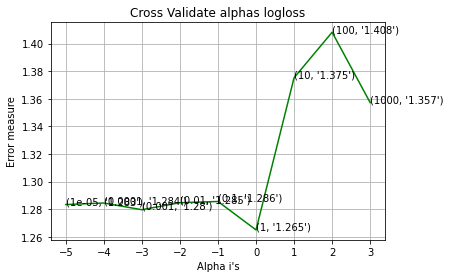

Logloss for best alpha 1 on cross validate data is: 1.2649179491814637
Logloss for best alpha 1 on train data is: 0.9302775084598898
Logloss for best alpha 1 on test data is: 1.279367004825177


In [ ]:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
cv_log_error = []

for i in alpha:
  clf = MultinomialNB(alpha = i)
  clf.fit(train_onehotencode , y_train_onehotencode)
  sig_clf = CalibratedClassifierCV(clf , method='sigmoid')
  sig_clf.fit(train_onehotencode, y_train_onehotencode)
  y_predicted = sig_clf.predict_proba(cv_onehotencode)
  print("logloss for alpha",i,"is:",log_loss(y_cv_onehotencode , y_predicted, labels= clf.classes_, eps=1e-15))
  cv_log_error.append(log_loss(y_cv_onehotencode , y_predicted, labels= clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error, c='g')
for i, txt in enumerate(np.round(cv_log_error, 3)):
  ax.annotate((alpha[i],str(txt)) , (np.log10(alpha[i]), np.round(cv_log_error[i],3)))
plt.grid()
plt.xticks(np.log10(alpha))
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.title("Cross Validate alphas logloss")
plt.show()

best_alpha = np.argmin(cv_log_error)
clf = MultinomialNB(alpha= alpha[best_alpha])
clf.fit(train_onehotencode , y_train_onehotencode)
sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
sig_clf.fit(train_onehotencode, y_train_onehotencode)

y_predicted = sig_clf.predict_proba(cv_onehotencode)
print("Logloss for best alpha",alpha[best_alpha], "on cross validate data is:",log_loss(y_cv_onehotencode, y_predicted, labels=clf.classes_, eps=1e-15))

y_predicted = sig_clf.predict_proba(train_onehotencode)
print("Logloss for best alpha", alpha[best_alpha], "on train data is:", log_loss(y_train_onehotencode, y_predicted, labels= clf.classes_, eps=1e-15))

y_predicted = sig_clf.predict_proba(test_onehotencode)
print("Logloss for best alpha",alpha[best_alpha], "on test data is:", log_loss(y_test_onehotencode, y_predicted, labels=clf.classes_, eps=1e-15))



Logloss: 1.2649179491814637
Number of misclassified points:  0.37969924812030076
------------------------------------------------------------ Confusion matrix ------------------------------------------------------------


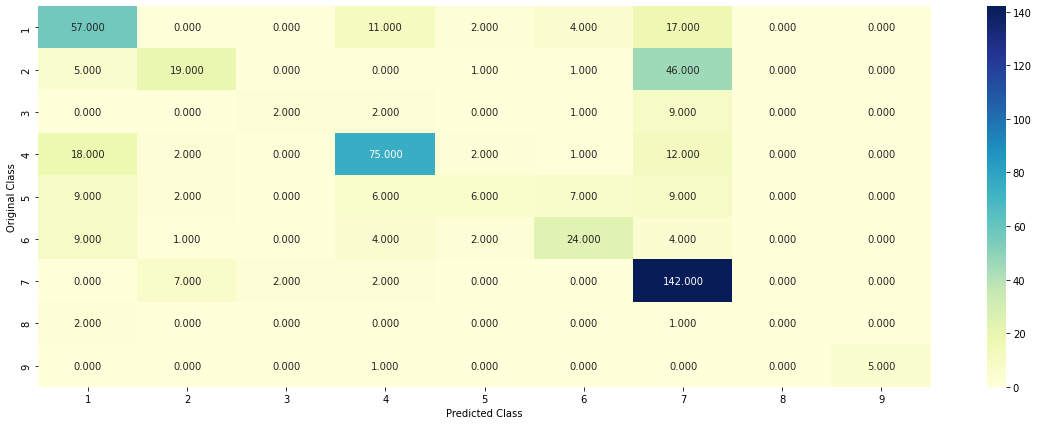

------------------------------------------------------------ Precision Martix axis=1 ------------------------------------------------------------


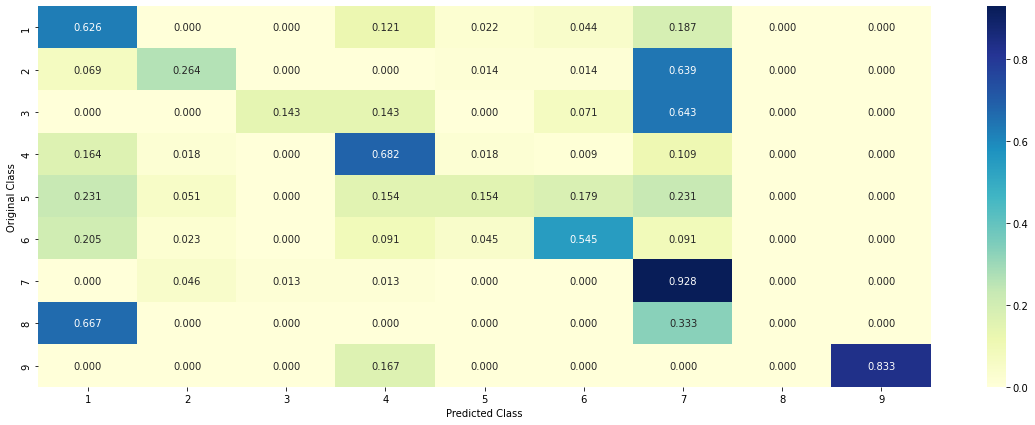

------------------------------------------------------------ Recall Martix axis=0 ------------------------------------------------------------


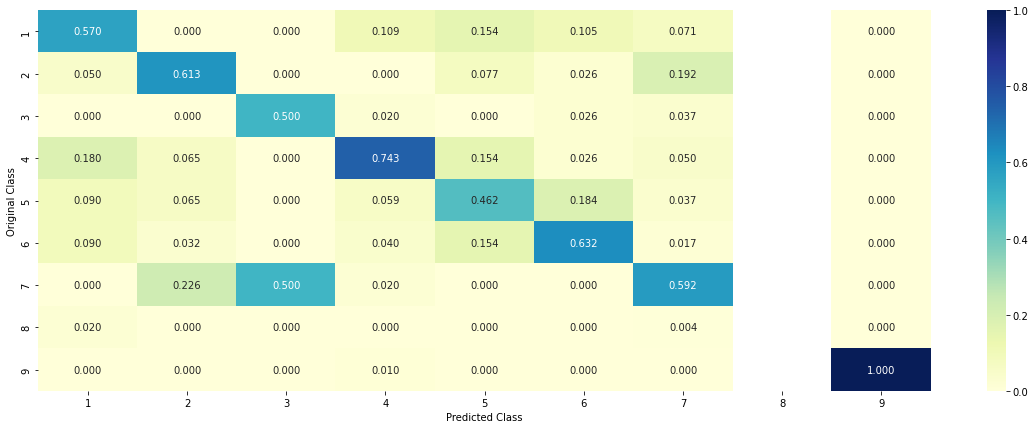

In [ ]:
clf = MultinomialNB(alpha = alpha[best_alpha])
clf.fit(train_onehotencode, y_train_onehotencode)
sig_clf = CalibratedClassifierCV(clf , method='sigmoid')
sig_clf.fit(train_onehotencode, y_train_onehotencode)
y_predicted = sig_clf.predict_proba(cv_onehotencode)    # use sig_clf.predict_proba
print("Logloss:", log_loss(y_cv_onehotencode , y_predicted))
print("Number of misclassified points: ",np.count_nonzero((sig_clf.predict(cv_onehotencode) - y_cv_onehotencode)) / y_cv_onehotencode.shape[0])     # use sig_clf.predict
plot_confusion_matrix(y_cv_onehotencode, sig_clf.predict(cv_onehotencode.toarray()))

<h3> Testing the MultinomialNB model.

In [ ]:
clf = MultinomialNB(alpha= alpha[best_alpha])
clf.fit(train_onehotencode,y_train_onehotencode)
test_point_index = 1
no_features = 100
predicted_cls = sig_clf.predict(test_onehotencode[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_onehotencode[test_point_index]),4))
print("Actual Class :", y_test_onehotencode[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_features]
print("-"*50)
get_impfeature_names(indices[0], x_test['TEXT'].iloc[test_point_index],x_test['Gene'].iloc[test_point_index],x_test['Variation'].iloc[test_point_index], no_features)

Predicted Class : 1
Predicted Class Probabilities: [[0.5951 0.0958 0.0242 0.1018 0.053  0.0384 0.0798 0.007  0.0049]]
Actual Class : 1
--------------------------------------------------


KeyboardInterrupt: ignored

<h3> Modelling with KNN using Response Coding.

In [ ]:
cv_log_error = []
alpha = [3, 5, 7, 9, 13, 17, 33, 53, 77, 99, 103, 109]
for i in alpha:
  clf = KNeighborsClassifier(n_jobs=-1, n_neighbors= i)
  clf.fit(train_ResponseCode, y_train_onehotencode)
  sig_clf = CalibratedClassifierCV(clf , method="sigmoid")
  sig_clf.fit(train_ResponseCode, y_train_onehotencode)
  predicted_y = sig_clf.predict_proba(cv_ResponseCode)
  cv_log_error.append(log_loss(y_cv_onehotencode, predicted_y, labels = clf.classes_ , eps=1e-15))
  print("Logloss is: ", log_loss(y_cv_onehotencode, predicted_y, labels = clf.classes_ , eps=1e-15))

fig,ax = plt.subplots()
ax.plot(alpha , cv_log_error , c='g')
for i , txt in enumerate(np.round(cv_log_error,3)):
  ax.annotate((alpha[i], str(txt)) , (alpha[i] , np.round(cv_log_error[i],3)))
plt.xlabel("Alpha i's")
plt.ylabel("Error loss")
plt.title("Cross Validate Log loss")
plt.grid()
plt.show()

best_alpha = np.argmin(cv_log_error)
clf = KNeighborsClassifier(n_jobs= -1, n_neighbors= alpha[best_alpha])
clf.fit(train_ResponseCode, y_train_onehotencode)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_ResponseCode, y_train_onehotencode)

predicted_y = sig_clf.predict_proba(test_ResponseCode)
print("Logloss for best alpha" , alpha[best_alpha],"Test data: ",log_loss(y_test_onehotencode , predicted_y , labels = clf.classes_, eps=1e-15))

predicted_y = sig_clf.predict_proba(train_ResponseCode)
print("Logloss for " , alpha[best_alpha],"Train data: ",log_loss(y_train_onehotencode , predicted_y , labels = clf.classes_, eps=1e-15))

predicted_y = sig_clf.predict_proba(cv_ResponseCode)
print("Logloss for " , alpha[best_alpha]," Cross Validate data: ",log_loss(y_cv_onehotencode , predicted_y , labels = clf.classes_, eps=1e-15))


In [ ]:
clf = KNeighborsClassifier(n_neighbors = alpha[best_alpha] , n_jobs= -1)
predict_and_plot_confusion_matrix(train_ResponseCode, y_train_onehotencode , cv_ResponseCode, y_cv_onehotencode , clf)

<h3> Modelling with KNN using OneHot Encoding.

In [ ]:
cv_log_error = []
alpha = [3, 5, 7, 9, 13, 17, 33, 53, 77, 99, 103, 109]
for i in alpha:
  clf = KNeighborsClassifier(n_jobs=-1, n_neighbors= i)
  clf.fit(train_onehotencode, y_train_onehotencode)
  sig_clf = CalibratedClassifierCV(clf , method="sigmoid")
  sig_clf.fit(train_onehotencode, y_train_onehotencode)
  predicted_y = sig_clf.predict_proba(cv_onehotencode)
  cv_log_error.append(log_loss(y_cv, predicted_y, labels = clf.classes_ , eps=1e-15))
  print("Logloss is: ", log_loss(y_cv, predicted_y, labels = clf.classes_ , eps=1e-15))

fig,ax = plt.subplots()
ax.plot(alpha , cv_log_error , c='g')
for i , txt in enumerate(np.round(cv_log_error,3)):
  ax.annotate((alpha[i], str(txt)) , (alpha[i] , np.round(cv_log_error[i],3)))
plt.xlabel("Alpha i's")
plt.ylabel("Error loss")
plt.title("Cross Validate Log loss")
plt.grid()
plt.show()

best_alpha = np.argmin(cv_log_error)
clf = KNeighborsClassifier(n_jobs= -1, n_neighbors= alpha[best_alpha])
clf.fit(train_onehotencode, y_train_onehotencode)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_onehotencode, y_train_onehotencode)

predicted_y = sig_clf.predict_proba(test_onehotencode)
print("Logloss for best alpha" , alpha[best_alpha],"Test data: ",log_loss(y_test_onehotencode , predicted_y , labels = clf.classes_, eps=1e-15))

predicted_y = sig_clf.predict_proba(train_onehotencode)
print("Logloss for " , alpha[best_alpha],"Train data: ",log_loss(y_train_onehotencode , predicted_y , labels = clf.classes_, eps=1e-15))

predicted_y = sig_clf.predict_proba(cv_onehotencode)
print("Logloss for " , alpha[best_alpha]," Cross Validate data: ",log_loss(y_cv_onehotencode , predicted_y , labels = clf.classes_, eps=1e-15))


In [ ]:
test_datapoint = 1
clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=alpha[best_alpha])
clf.fit(train_ResponseCode, y_train_onehotencode)
sig_clf = CalibratedClassifierCV(clf, method= 'sigmoid')
predicted_class = sig_clf.predict(test_ResponseCode[test_datapoint])



<h3>Modelling by Logistic Regression with balance class weights using OneHot Encoding.

For alpha  1e-05  the log loss is:  1.2473875785582018
For alpha  0.0001  the log loss is:  1.0748413470926341
For alpha  0.001  the log loss is:  1.0485951395432134
For alpha  0.01  the log loss is:  1.1325258669671847
For alpha  0.1  the log loss is:  1.444243997320998
For alpha  1  the log loss is:  1.6766154984589832
For alpha  10  the log loss is:  1.7046724931949284


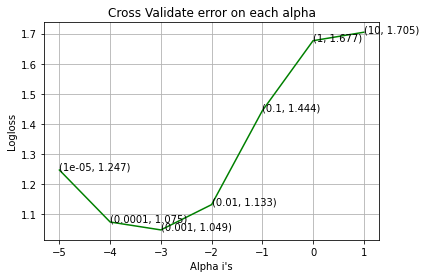

For alpha  0.001 the test logloss is:  1.0707726300779963
For alpha  0.001 the cross validate logloss is:  1.0485951395432134
For alpha  0.001 the train logloss is:  0.5288145361128199


In [ ]:
alpha = [10 ** x for x in range(-5,2)]
cv_log_error = []
for i in alpha:
  clf = SGDClassifier(alpha = i , class_weight = 'balanced', penalty = 'l2' , loss= 'log' , random_state = 42 , n_jobs=-1)
  clf.fit(train_onehotencode , y_train_onehotencode)
  sig_clf = CalibratedClassifierCV(clf , method='sigmoid')
  sig_clf.fit(train_onehotencode , y_train_onehotencode)

  y_predicted = sig_clf.predict_proba(cv_onehotencode)
  cv_log_error.append(log_loss(y_cv_onehotencode , y_predicted , labels = clf.classes_ , eps=1e-15))
  print("For alpha ",i," the log loss is: ", log_loss(y_cv_onehotencode , y_predicted , labels= clf.classes_ , eps= 1e-15))

fig , ax = plt.subplots()
ax.plot(np.log10(alpha) , cv_log_error , c='g')
for i , txt in enumerate(np.round(cv_log_error , 3)):
  ax.annotate((alpha[i] , np.round(txt,3)) , (np.log10(alpha[i]) , cv_log_error[i]))
plt.title("Cross Validate error on each alpha")
plt.xticks(np.log10(alpha))
plt.xlabel("Alpha i's")
plt.ylabel("Logloss")
plt.grid()
plt.show()

best_alpha = np.argmin(cv_log_error)

clf = SGDClassifier(alpha = alpha[best_alpha] ,class_weight='balanced' , penalty = 'l2', loss = 'log', random_state=42, n_jobs=-1)
clf.fit(train_text_onehotencode , y_train_onehotencode)
sig_clf = CalibratedClassifierCV(clf , method = 'sigmoid')
sig_clf.fit(train_onehotencode , y_train_onehotencode)
y_predicted = sig_clf.predict_proba(test_onehotencode)
print("For alpha ",alpha[best_alpha],"the test logloss is: ", log_loss(y_test_onehotencode , y_predicted , labels= clf.classes_ , eps=1e-15))
y_predicted = sig_clf.predict_proba(cv_onehotencode)
print("For alpha ",alpha[best_alpha],"the cross validate logloss is: ", log_loss(y_cv_onehotencode , y_predicted , labels= clf.classes_ , eps=1e-15))
y_predicted = sig_clf.predict_proba(train_onehotencode)
print("For alpha ",alpha[best_alpha],"the train logloss is: ", log_loss(y_train_onehotencode , y_predicted , labels= clf.classes_ , eps=1e-15))


Logloss is:  1.0485951395432134
Number of mis-classified points : 0.325187969924812
------------------------------------------------------------ Confusion matrix ------------------------------------------------------------


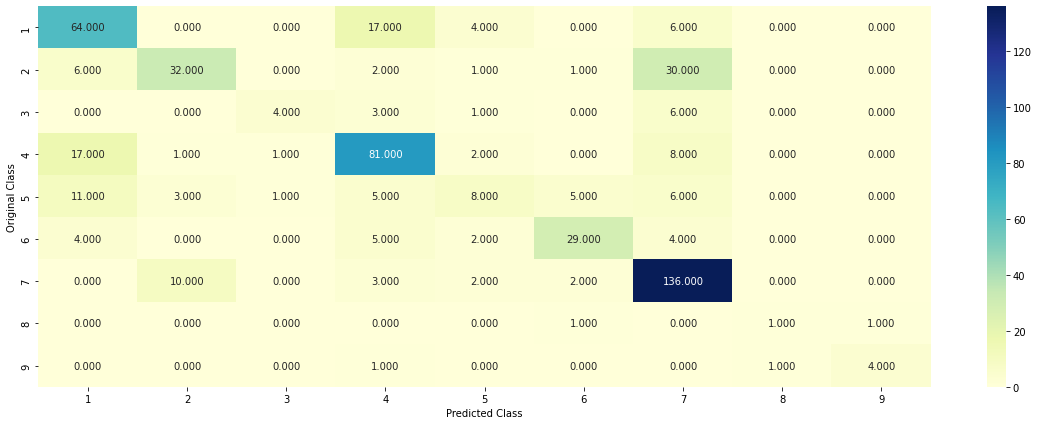

------------------------------------------------------------ Precision Martix axis=1 ------------------------------------------------------------


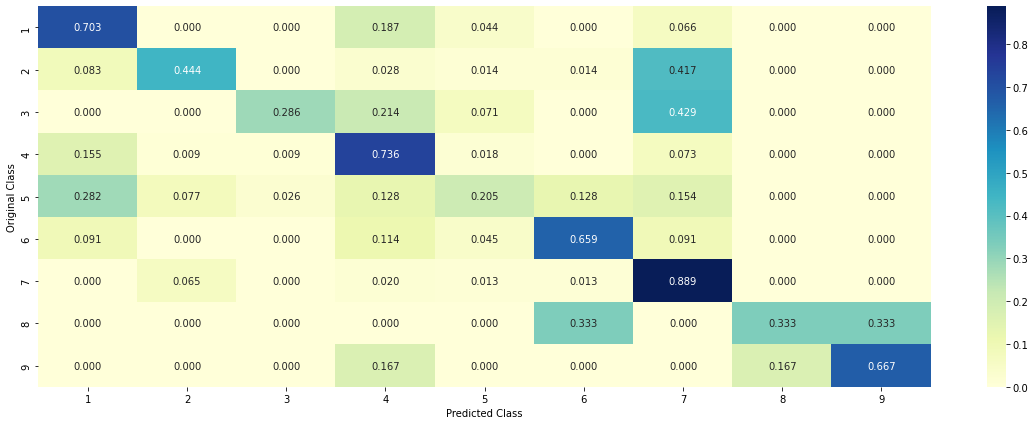

------------------------------------------------------------ Recall Martix axis=0 ------------------------------------------------------------


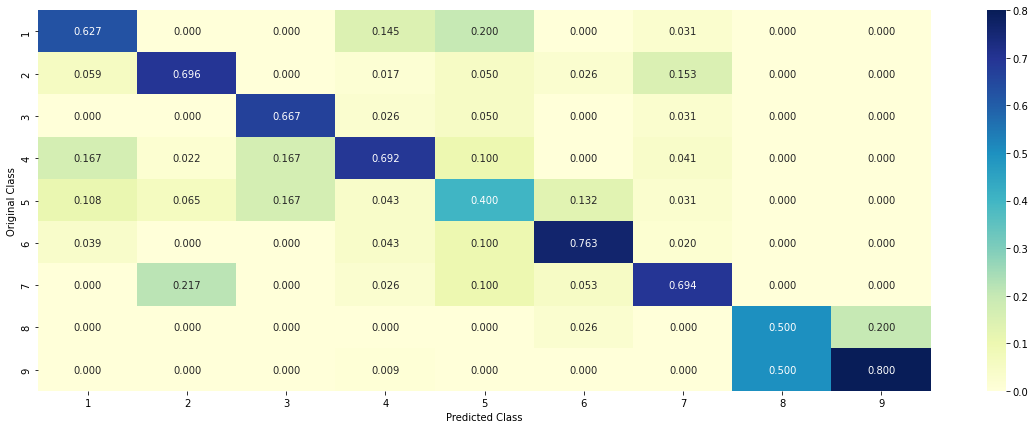

In [ ]:
clf = SGDClassifier(alpha = alpha[best_alpha] , class_weight = 'balanced', penalty = 'l2' , loss= 'log' , random_state = 42 , n_jobs=-1)
predict_and_plot_confusion_matrix(train_onehotencode , y_train_onehotencode, cv_onehotencode, y_cv_onehotencode, clf)

<h3>Modelling by Logistic Regression without balance class weights using OneHot Encoding.

For alpha  1e-05  the log loss is:  1.2081297923398033
For alpha  0.0001  the log loss is:  1.0762558401778575
For alpha  0.001  the log loss is:  1.066821961771742
For alpha  0.01  the log loss is:  1.185345300279447
For alpha  0.1  the log loss is:  1.3655363881095843
For alpha  1  the log loss is:  1.5875084802850978
For alpha  10  the log loss is:  1.6317954052105024


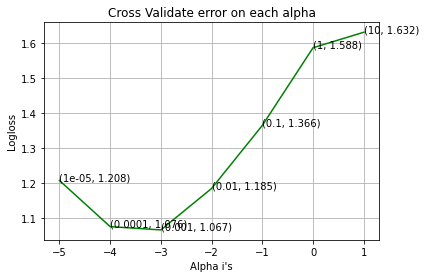

For alpha  0.001 the test logloss is:  1.0913634713092308
For alpha  0.001 the cross validate logloss is:  1.066821961771742
For alpha  0.001 the train logloss is:  0.5316078936690953


In [ ]:
alpha = [10 ** x for x in range(-5,2)]
cv_log_error = []
for i in alpha:
  clf = SGDClassifier(alpha = i , penalty = 'l2' , loss= 'log' , random_state = 42 , n_jobs=-1)
  clf.fit(train_onehotencode , y_train_onehotencode)
  sig_clf = CalibratedClassifierCV(clf , method='sigmoid')
  sig_clf.fit(train_onehotencode , y_train_onehotencode)
  y_predicted = sig_clf.predict_proba(cv_onehotencode)
  cv_log_error.append(log_loss(y_cv_onehotencode , y_predicted , labels = clf.classes_ , eps=1e-15))
  print("For alpha ",i," the log loss is: ", log_loss(y_cv_onehotencode , y_predicted , labels= clf.classes_ , eps= 1e-15))

fig , ax = plt.subplots()
ax.plot(np.log10(alpha) , cv_log_error , c='g')
for i , txt in enumerate(np.round(cv_log_error , 3)):
  ax.annotate((alpha[i] , np.round(txt,3)) , (np.log10(alpha[i]) , cv_log_error[i]))
plt.title("Cross Validate error on each alpha")
plt.xticks(np.log10(alpha))
plt.xlabel("Alpha i's")
plt.ylabel("Logloss")
plt.grid()
plt.show()

best_alpha = np.argmin(cv_log_error)

clf = SGDClassifier(alpha = alpha[best_alpha] , penalty = 'l2', loss = 'log', random_state=42, n_jobs=-1)
clf.fit(train_text_onehotencode , y_train_onehotencode)
sig_clf = CalibratedClassifierCV(clf , method = 'sigmoid')
sig_clf.fit(train_onehotencode , y_train_onehotencode)
y_predicted = sig_clf.predict_proba(test_onehotencode)
print("For alpha ",alpha[best_alpha],"the test logloss is: ", log_loss(y_test_onehotencode , y_predicted , labels= clf.classes_ , eps=1e-15))
y_predicted = sig_clf.predict_proba(cv_onehotencode)
print("For alpha ",alpha[best_alpha],"the cross validate logloss is: ", log_loss(y_cv_onehotencode , y_predicted , labels= clf.classes_ , eps=1e-15))
y_predicted = sig_clf.predict_proba(train_onehotencode)
print("For alpha ",alpha[best_alpha],"the train logloss is: ", log_loss(y_train_onehotencode , y_predicted , labels= clf.classes_ , eps=1e-15))


Logloss is:  1.066821961771742
Number of mis-classified points : 0.325187969924812
------------------------------------------------------------ Confusion matrix ------------------------------------------------------------


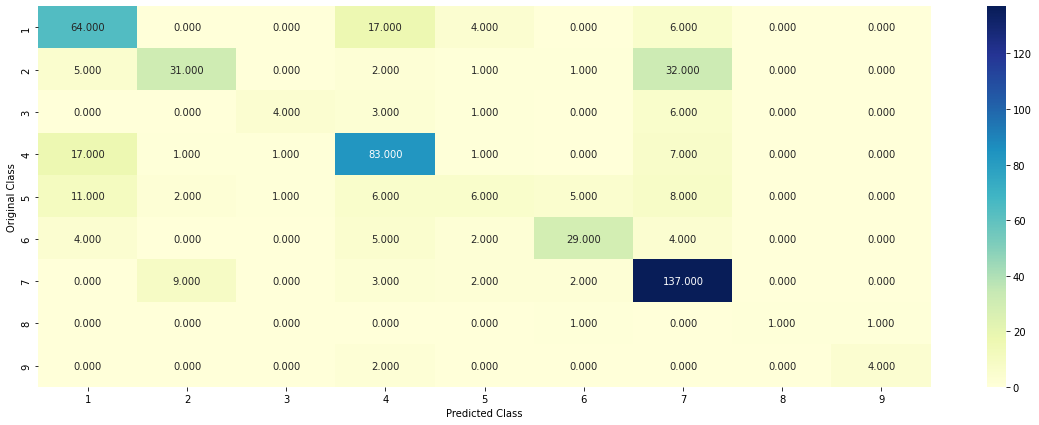

------------------------------------------------------------ Precision Martix axis=1 ------------------------------------------------------------


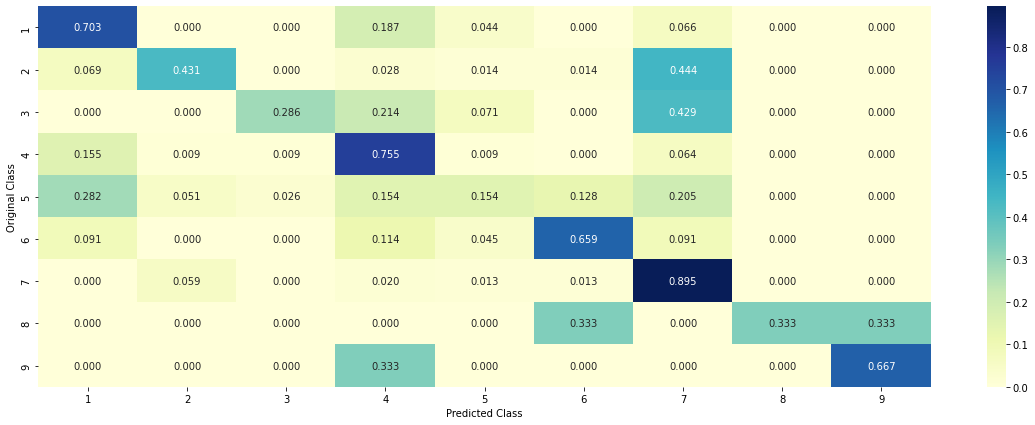

------------------------------------------------------------ Recall Martix axis=0 ------------------------------------------------------------


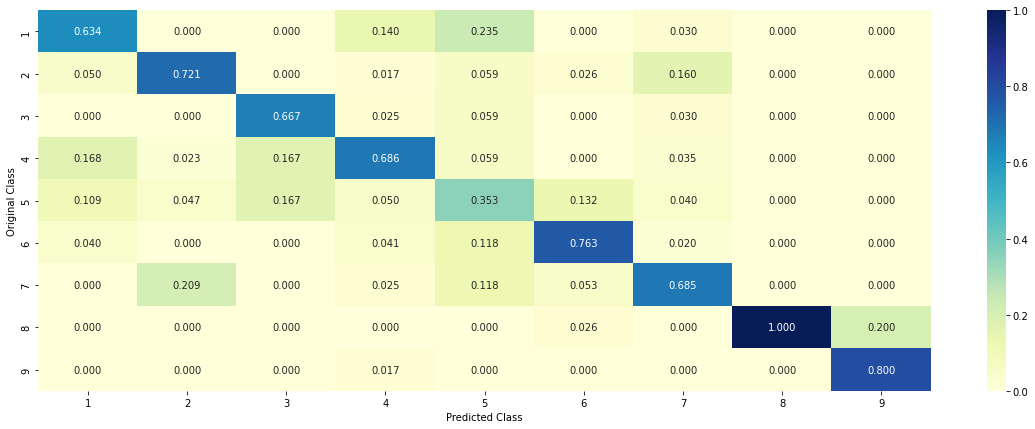

In [ ]:
clf = SGDClassifier(alpha = alpha[best_alpha] , penalty = 'l2' , loss= 'log' , random_state = 42 , n_jobs=-1)
predict_and_plot_confusion_matrix(train_onehotencode , y_train_onehotencode, cv_onehotencode, y_cv_onehotencode, clf)

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_onehotencode,y_train_onehotencode)
test_point_index = 1
no_features = 100
predicted_cls = sig_clf.predict(test_onehotencode[test_point_index])
print("Predicted Class :", predicted_cls[0], '\n',np.max(np.round(sig_clf.predict_proba(test_onehotencode[test_point_index]),4)*100), "% ")
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_onehotencode[test_point_index]),4))
print("Actual Class :", y_test_onehotencode[test_point_index] )
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_features]
print("-"*50)
get_impfeature_names(indices[0], x_test['TEXT'].iloc[test_point_index],x_test['Gene'].iloc[test_point_index],x_test['Variation'].iloc[test_point_index], no_features)

Predicted Class : 4 
 69.27 % sure that the 
Predicted Class Probabilities: [[0.06   0.0778 0.0207 0.6927 0.0457 0.0384 0.0549 0.0055 0.0043]]
Actual Class : 4
--------------------------------------------------
29 Text feature [identified] present in test data point [True]
30 Text feature [well] present in test data point [True]
31 Text feature [observed] present in test data point [True]
33 Text feature [additional] present in test data point [True]
34 Text feature [recently] present in test data point [True]
37 Text feature [previously] present in test data point [True]
38 Text feature [using] present in test data point [True]
41 Text feature [mutation] present in test data point [True]
42 Text feature [found] present in test data point [True]
43 Text feature [one] present in test data point [True]
44 Text feature [studies] present in test data point [True]
45 Text feature [also] present in test data point [True]
46 Text feature [however] present in test data point [True]
47 Text fea

For C=  1e-05  the log loss is:  1.2506158250899744
For C=  0.0001  the log loss is:  1.1643879914712791
For C=  0.001  the log loss is:  1.0947252970329808
For C=  0.01  the log loss is:  1.1264490587268021
For C=  0.1  the log loss is:  1.3692839515352673
For C=  1  the log loss is:  1.6920532196555274
For C=  10  the log loss is:  1.7081851551357823


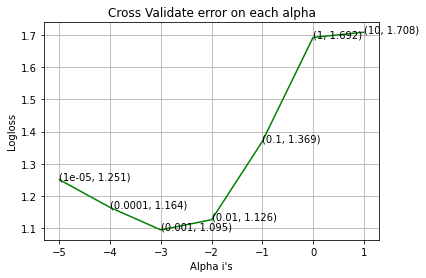

For C=  0.001 the test logloss is:  1.1529109431637767
For C=  0.001 the cross validate logloss is:  1.0947252970329808
For C=  0.001 the train logloss is:  0.5481320621722389


In [ ]:
alpha = [10 ** x for x in range(-5,2)]
cv_log_error = []
for i in alpha:
  clf = SGDClassifier(alpha = i , class_weight = 'balanced', penalty = 'l2' , loss= 'hinge' , random_state = 42 , n_jobs=-1)
  clf.fit(train_onehotencode , y_train_onehotencode)
  sig_clf = CalibratedClassifierCV(clf , method='sigmoid')
  sig_clf.fit(train_onehotencode , y_train_onehotencode)

  y_predicted = sig_clf.predict_proba(cv_onehotencode)
  cv_log_error.append(log_loss(y_cv_onehotencode , y_predicted , labels = clf.classes_ , eps=1e-15))
  print("For C= ",i," the log loss is: ", log_loss(y_cv_onehotencode , y_predicted , labels= clf.classes_ , eps= 1e-15))

fig , ax = plt.subplots()
ax.plot(np.log10(alpha) , cv_log_error , c='g')
for i , txt in enumerate(np.round(cv_log_error , 3)):
  ax.annotate((alpha[i] , np.round(txt,3)) , (np.log10(alpha[i]) , cv_log_error[i]))
plt.title("Cross Validate error on each alpha")
plt.xticks(np.log10(alpha))
plt.xlabel("Alpha i's")
plt.ylabel("Logloss")
plt.grid()
plt.show()

best_alpha = np.argmin(cv_log_error)

clf = SGDClassifier(alpha = alpha[best_alpha] ,class_weight='balanced' , penalty = 'l2', loss = 'hinge', random_state=42, n_jobs=-1)
clf.fit(train_text_onehotencode , y_train_onehotencode)
sig_clf = CalibratedClassifierCV(clf , method = 'sigmoid')
sig_clf.fit(train_onehotencode , y_train_onehotencode)
y_predicted = sig_clf.predict_proba(test_onehotencode)
print("For C= ",alpha[best_alpha],"the test logloss is: ", log_loss(y_test_onehotencode , y_predicted , labels= clf.classes_ , eps=1e-15))
y_predicted = sig_clf.predict_proba(cv_onehotencode)
print("For C= ",alpha[best_alpha],"the cross validate logloss is: ", log_loss(y_cv_onehotencode , y_predicted , labels= clf.classes_ , eps=1e-15))
y_predicted = sig_clf.predict_proba(train_onehotencode)
print("For C= ",alpha[best_alpha],"the train logloss is: ", log_loss(y_train_onehotencode , y_predicted , labels= clf.classes_ , eps=1e-15))

Logloss is:  1.0947252970329808
Number of mis-classified points : 0.31390977443609025
------------------------------------------------------------ Confusion matrix ------------------------------------------------------------


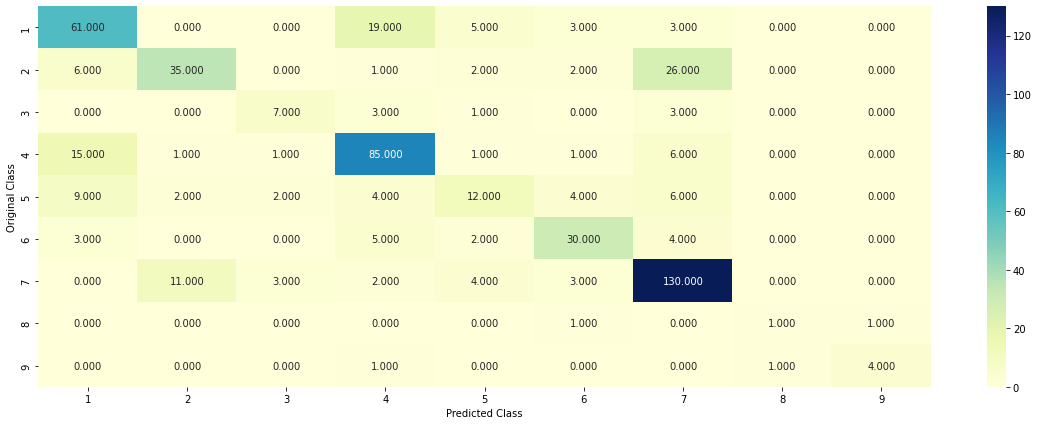

------------------------------------------------------------ Precision Martix axis=1 ------------------------------------------------------------


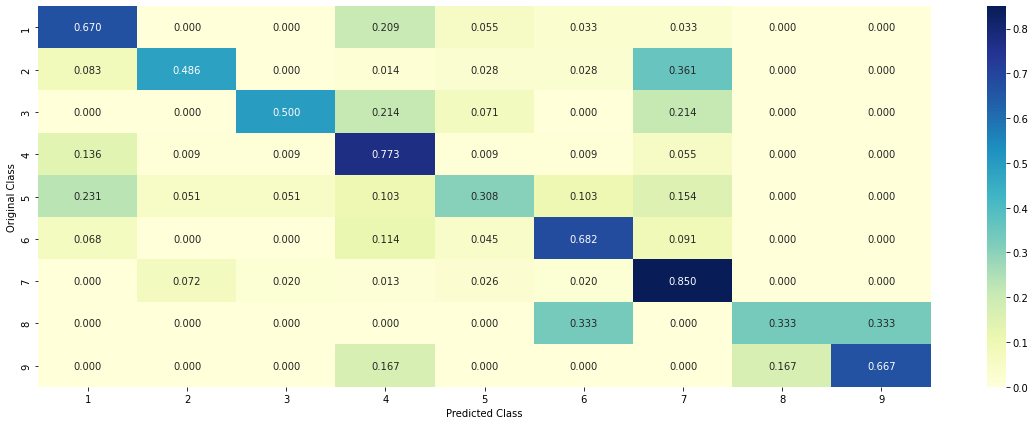

------------------------------------------------------------ Recall Martix axis=0 ------------------------------------------------------------


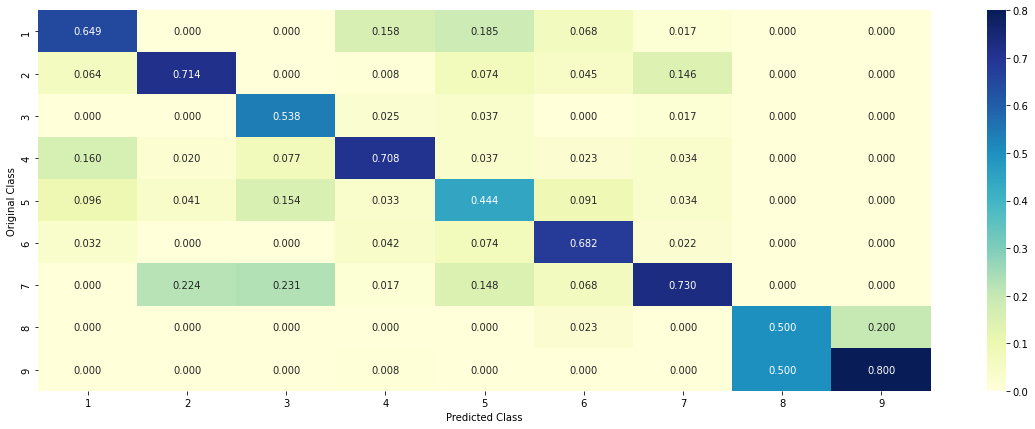

In [ ]:
clf = SGDClassifier(alpha = alpha[best_alpha] ,class_weight='balanced' , penalty = 'l2', loss = 'hinge', random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_onehotencode, y_train_onehotencode , cv_onehotencode, y_cv_onehotencode, clf)

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], class_weight='balanced', penalty='l2', loss='hinge', random_state=42)
clf.fit(train_onehotencode,y_train_onehotencode)
test_point_index = 1
no_features = 500
predicted_cls = sig_clf.predict(test_onehotencode[test_point_index])
print("Predicted Class :", predicted_cls[0], '\n',np.max(np.round(sig_clf.predict_proba(test_onehotencode[test_point_index]),4)*100), "% ")
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_onehotencode[test_point_index]),4))
print("Actual Class :", y_test_onehotencode[test_point_index] )
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_features]
print("-"*50)
get_impfeature_names(indices[0], x_test['TEXT'].iloc[test_point_index],x_test['Gene'].iloc[test_point_index],x_test['Variation'].iloc[test_point_index], no_features)

Predicted Class : 4 
 78.10000000000001 % 
Predicted Class Probabilities: [[0.0165 0.0576 0.005  0.781  0.0321 0.0155 0.0837 0.004  0.0045]]
Actual Class : 4
--------------------------------------------------
195 Text feature [spell] present in test data point [True]
254 Text feature [n239s] present in test data point [True]
330 Text feature [foa] present in test data point [True]
332 Text feature [y234c] present in test data point [True]
379 Text feature [dbs] present in test data point [True]
400 Text feature [r158l] present in test data point [True]
468 Text feature [stressgen] present in test data point [True]
Out of the top  500  features  7 are present in query point


 <h3>Modelling with Random Forest using OneHot Encoding.


For n_estimators=  5  and the max_depth  5 logloss is:  1.4994687320531899
For n_estimators=  5  and the max_depth  10 logloss is:  1.3663067577448709
For n_estimators=  10  and the max_depth  5 logloss is:  1.445546235693778
For n_estimators=  10  and the max_depth  10 logloss is:  1.2894108103488713
For n_estimators=  155  and the max_depth  5 logloss is:  1.285538856272138
For n_estimators=  155  and the max_depth  10 logloss is:  1.1898160739367794
For n_estimators=  125  and the max_depth  5 logloss is:  1.2867590923292425
For n_estimators=  125  and the max_depth  10 logloss is:  1.192998090005966
For n_estimators=  225  and the max_depth  5 logloss is:  1.2727958979247436
For n_estimators=  225  and the max_depth  10 logloss is:  1.1844112130579874
For n_estimators=  1000  and the max_depth  5 logloss is:  1.2577234208946462
For n_estimators=  1000  and the max_depth  10 logloss is:  1.1796728464443378


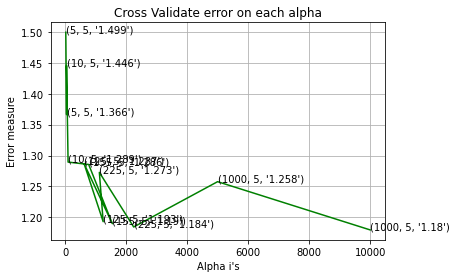

For value of best estimator  1000 the test logloss is:  1.2542306850241645
For value of best estimator  1000 the cross validate logloss is:  1.2577234208946462
For value of best estimator  1000 the train logloss is:  1.0308767091863429


In [ ]:
alpha = [5,10,155,125,225,1000]
max_depth = [5,10]
cv_log_error = []
for i in alpha:
  for j in max_depth:
    clf = RandomForestClassifier(n_estimators = i, max_depth=j, criterion='gini' , random_state = 42 , n_jobs=-1)
    clf.fit(train_onehotencode , y_train_onehotencode)
    sig_clf = CalibratedClassifierCV(clf , method='sigmoid')
    sig_clf.fit(train_onehotencode , y_train_onehotencode)

    y_predicted = sig_clf.predict_proba(cv_onehotencode)
    cv_log_error.append(log_loss(y_cv_onehotencode , y_predicted , labels = clf.classes_ , eps=1e-15))
    print("For n_estimators= ",i," and the max_depth ",j, "logloss is: ", log_loss(y_cv_onehotencode , y_predicted , labels= clf.classes_ , eps= 1e-15))

fig , ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None] , np.array(max_depth)[None]).ravel()
ax.plot((features) , cv_log_error , c='g')
for i , txt in enumerate(np.round(cv_log_error , 3)):
  ax.annotate((alpha[int(i/2)] , max_depth[int(j%2)] , str(txt)) ,(features[i] , cv_log_error[i]))
plt.title("Cross Validate error on each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.grid()
plt.show()

best_alpha = np.argmin(cv_log_error)

clf = RandomForestClassifier(n_estimators = alpha[int(best_alpha/2)] ,max_depth=max_depth[int(j%2)], criterion = 'gini', random_state=42, n_jobs=-1)
clf.fit(train_onehotencode , y_train_onehotencode)
sig_clf = CalibratedClassifierCV(clf , method = 'sigmoid')
sig_clf.fit(train_onehotencode , y_train_onehotencode)
y_predicted = sig_clf.predict_proba(test_onehotencode)
print("For value of best estimator ",alpha[int(best_alpha/2)],"the test logloss is: ", log_loss(y_test_onehotencode , y_predicted , labels= clf.classes_ , eps=1e-15))
y_predicted = sig_clf.predict_proba(cv_onehotencode)
print("For value of best estimator ",alpha[int(best_alpha/2)],"the cross validate logloss is: ", log_loss(y_cv_onehotencode , y_predicted , labels= clf.classes_ , eps=1e-15))
y_predicted = sig_clf.predict_proba(train_onehotencode)
print("For value of best estimator ",alpha[int(best_alpha/2)],"the train logloss is: ", log_loss(y_train_onehotencode , y_predicted , labels= clf.classes_ , eps=1e-15))

Logloss is:  1.2577234208946462
Number of mis-classified points : 0.40225563909774437
------------------------------------------------------------ Confusion matrix ------------------------------------------------------------


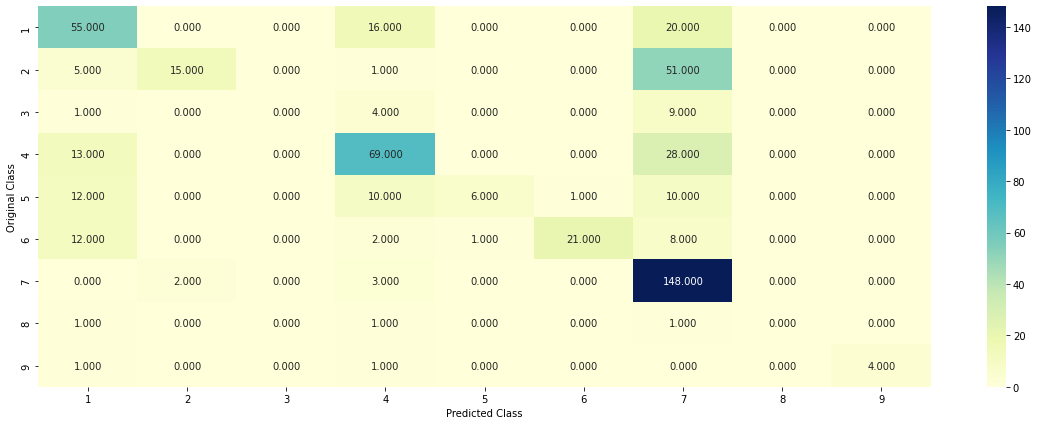

------------------------------------------------------------ Precision Martix axis=1 ------------------------------------------------------------


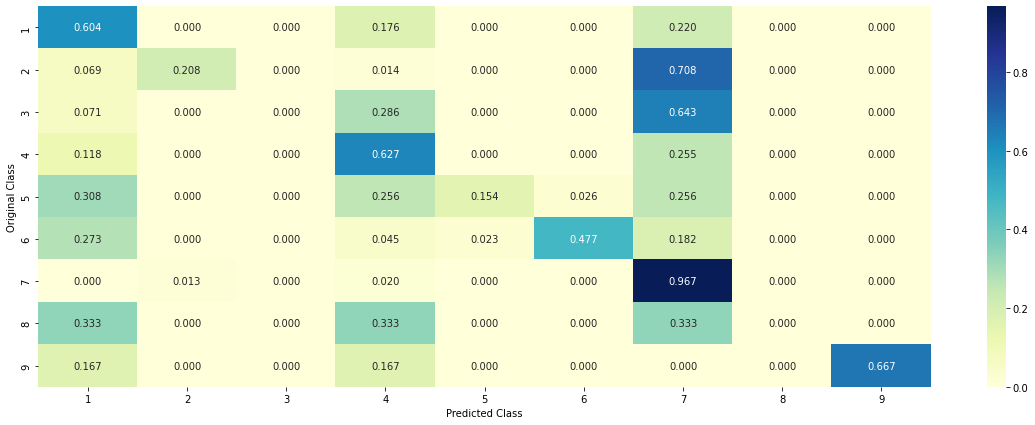

------------------------------------------------------------ Recall Martix axis=0 ------------------------------------------------------------


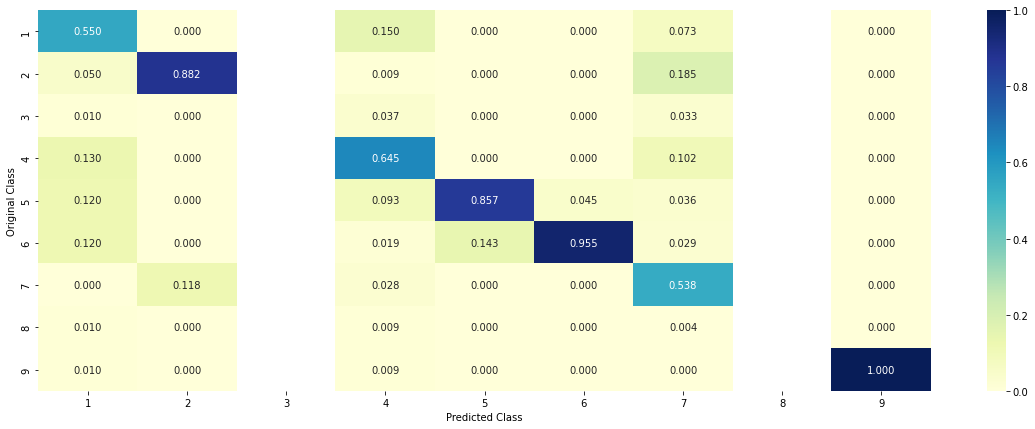

In [ ]:
clf = RandomForestClassifier(n_estimators = alpha[int(best_alpha/2)] ,max_depth=max_depth[int(j%2)], criterion = 'gini', random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_onehotencode, y_train_onehotencode, cv_onehotencode, y_cv_onehotencode, clf)

 <h3>Modelling with Random Forest using Response Coding.

For n_estimators=  5  and the max_depth  5 logloss is:  1.664747350090387
For n_estimators=  5  and the max_depth  10 logloss is:  1.831229176069789
For n_estimators=  10  and the max_depth  5 logloss is:  1.5295563002001502
For n_estimators=  10  and the max_depth  10 logloss is:  1.6134640703047571
For n_estimators=  15  and the max_depth  5 logloss is:  1.485906035960822
For n_estimators=  15  and the max_depth  10 logloss is:  1.8602628145419957
For n_estimators=  25  and the max_depth  5 logloss is:  1.5015272260678922
For n_estimators=  25  and the max_depth  10 logloss is:  1.871753233574049
For n_estimators=  500  and the max_depth  5 logloss is:  1.3717526896858698
For n_estimators=  500  and the max_depth  10 logloss is:  1.8563348451787494
For n_estimators=  1000  and the max_depth  5 logloss is:  1.3777292550486167
For n_estimators=  1000  and the max_depth  10 logloss is:  1.8335882151797402


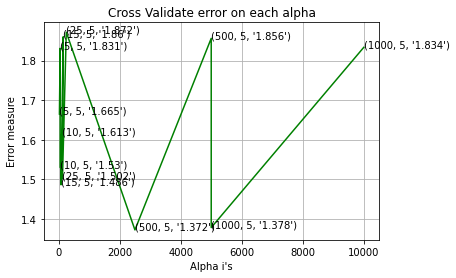

For value of best estimator  500 the test logloss is:  1.341510687550331
For value of best estimator  500 the cross validate logloss is:  1.3717526896858698
For value of best estimator  500 the train logloss is:  0.06273645975884622


In [ ]:
alpha = [5,10,15,25,500,1000]
max_depth = [5,10]
cv_log_error = []
for i in alpha:
  for j in max_depth:
    clf = RandomForestClassifier(n_estimators = i, max_depth=j, criterion='gini' , random_state = 42 , n_jobs=-1)
    clf.fit(train_ResponseCode , y_train_onehotencode)
    sig_clf = CalibratedClassifierCV(clf , method='sigmoid')
    sig_clf.fit(train_ResponseCode , y_train_onehotencode)

    y_predicted = sig_clf.predict_proba(cv_ResponseCode)
    cv_log_error.append(log_loss(y_cv_onehotencode , y_predicted , labels = clf.classes_ , eps=1e-15))
    print("For n_estimators= ",i," and the max_depth ",j, "logloss is: ", log_loss(y_cv_onehotencode , y_predicted , labels= clf.classes_ , eps= 1e-15))

fig , ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None] , np.array(max_depth)[None]).ravel()
ax.plot((features) , cv_log_error , c='g')
for i , txt in enumerate(np.round(cv_log_error , 3)):
  ax.annotate((alpha[int(i/2)] , max_depth[int(j%2)] , str(txt)) , (features[i] , cv_log_error[i]))
plt.title("Cross Validate error on each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.grid()
plt.show()

best_alpha = np.argmin(cv_log_error)

clf = RandomForestClassifier(n_estimators = alpha[int(best_alpha/2)] ,max_depth=max_depth[int(j%2)], criterion = 'gini', random_state=42, n_jobs=-1)
clf.fit(train_ResponseCode , y_train_onehotencode)
sig_clf = CalibratedClassifierCV(clf , method = 'sigmoid')
sig_clf.fit(train_ResponseCode , y_train_onehotencode)
y_predicted = sig_clf.predict_proba(test_ResponseCode)
print("For value of best estimator ",alpha[int(best_alpha/2)],"the test logloss is: ", log_loss(y_test_onehotencode , y_predicted , labels= clf.classes_ , eps=1e-15))
y_predicted = sig_clf.predict_proba(cv_ResponseCode)
print("For value of best estimator ",alpha[int(best_alpha/2)],"the cross validate logloss is: ", log_loss(y_cv_onehotencode , y_predicted , labels= clf.classes_ , eps=1e-15))
y_predicted = sig_clf.predict_proba(train_ResponseCode)
print("For value of best estimator ",alpha[int(best_alpha/2)],"the train logloss is: ", log_loss(y_train_onehotencode , y_predicted , labels= clf.classes_ , eps=1e-15))

Logloss is:  1.3717526896858698
Number of mis-classified points : 0.4906015037593985
------------------------------------------------------------ Confusion matrix ------------------------------------------------------------


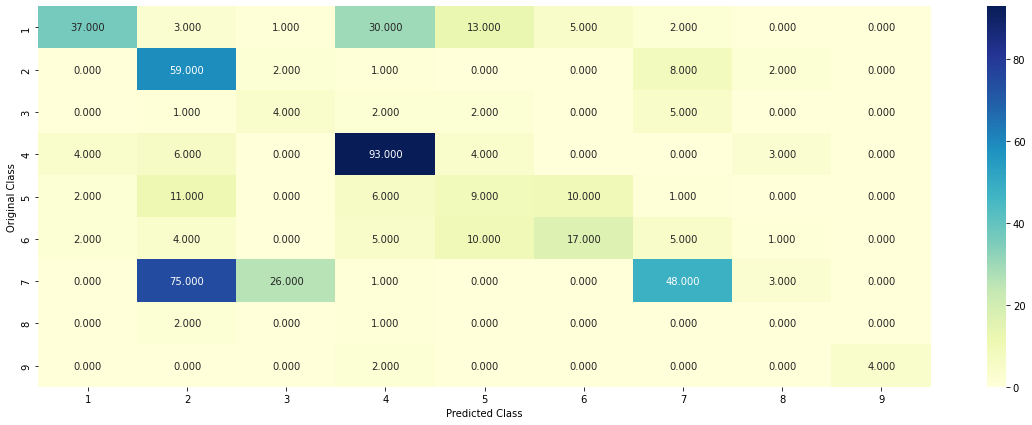

------------------------------------------------------------ Precision Martix axis=1 ------------------------------------------------------------


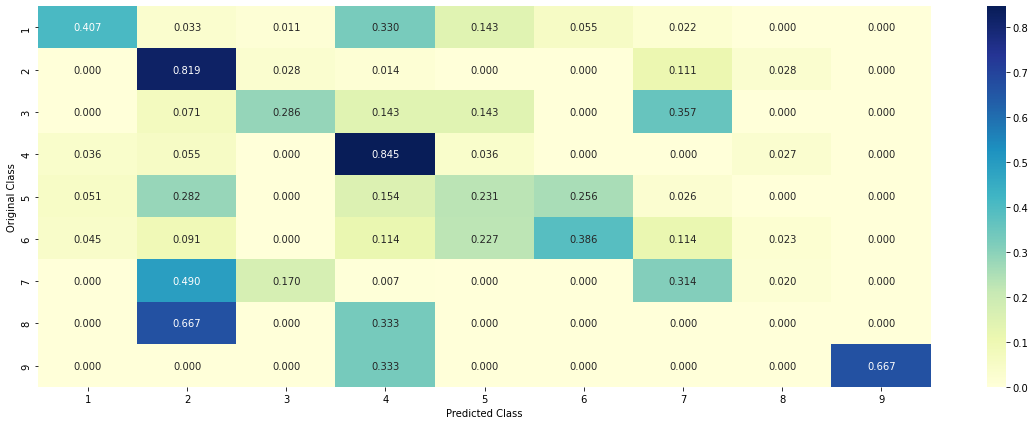

------------------------------------------------------------ Recall Martix axis=0 ------------------------------------------------------------


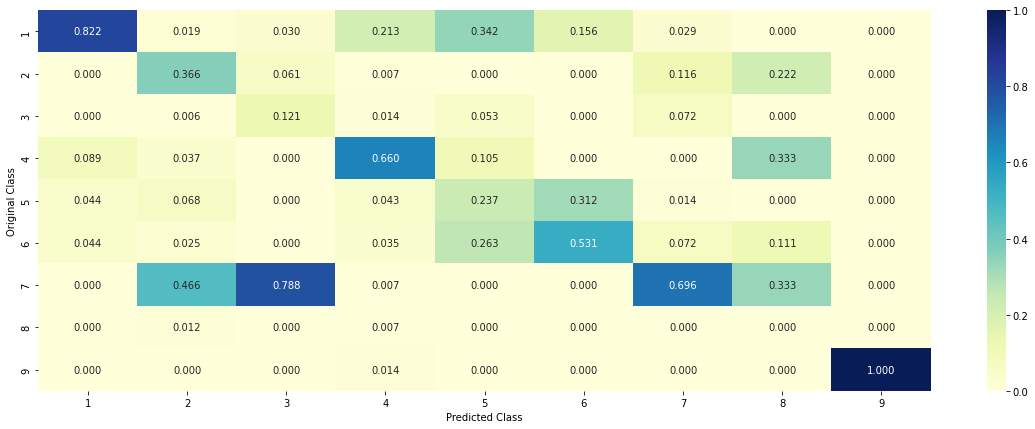

In [ ]:
clf = RandomForestClassifier(n_estimators = alpha[int(best_alpha/2)] ,max_depth=max_depth[int(j%2)], criterion = 'gini', random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_ResponseCode, y_train_onehotencode, cv_ResponseCode, y_cv_onehotencode, clf)